# **H1N1 and Swine Flu Vaccine Probability Classification**

This notebook serves as the workplace for the FindIT 2023 Data Analytics Competition hosted in Kaggle: https://www.kaggle.com/competitions/dac-find-it-2023.

The main goal is to create a model that can predict probabilities of a person getting either H1N1, Swine, or both flu vaccine. There are two target variables: `h1n1_vaccine` and `seasonal_vaccine`. Both cases are modeled using the XGBClassifier model, combined with a hyperparameter tuning process using Bayesian Optimization.

## Importing Packages

This whole notebook is ran using Google Colab. Therefore to easily integrate the dataset to the notebook, a mount to Google Drive is needed.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## Installing the skopt library
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.5 MB/s eta 0:00:00


In [6]:
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Importing sklearn modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score, roc_curve
from sklearn.feature_selection import f_regression, VarianceThreshold
from sklearn.impute import SimpleImputer
import pprint

## Importing ML Model
from xgboost import XGBClassifier, plot_importance, plot_tree

## Importing Skopt functions for Hyperparameter Optimization Process
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

In [8]:
## Load the required datasets from Google Drive
train_df_features = pd.read_csv('/content/drive/MyDrive/FindIT - DAC/training_set_features.csv', index_col = 0)
train_df_labels = pd.read_csv('/content/drive/MyDrive/FindIT - DAC/training_set_labels.csv', index_col = 0)
test_df = pd.read_csv('/content/drive/MyDrive/FindIT - DAC/test_set_features.csv', index_col = 0)
submissions = pd.read_csv('/content/drive/MyDrive/FindIT - DAC/submission_format.csv', index_col = 0)

## 1 - Data Overview

We will look at the data, looking at the features and the distributions

In [9]:
train_df_features

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN


In [10]:
train_df_labels

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0
...,...,...
26702,0,0
26703,0,0
26704,0,1


In [11]:
test_df

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53410,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,dqpwygqj,"MSA, Principle City",1.0,1.0,NaN,NaN
53411,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,Below Poverty,Married,Rent,Employed,qufhixun,Non-MSA,1.0,3.0,fcxhlnwr,vlluhbov
53412,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,qufhixun,"MSA, Not Principle City",1.0,0.0,NaN,NaN


Both training and test set has about 26707 rows, and looking from the 'respondent_id' index, it seems like the test dataset is taken from the 26707th respondent onwards.

Also, since the train features and labels are splitted, we can combine both for better observation.

In [12]:
train_df = pd.concat([train_df_features, train_df_labels], axis = 1)

Overview of the distribution of the dataset, starting with checking the missing values

In [ ]:
(train_df.isna().sum()/len(train_df))*100

h1n1_concern                    0.344479
h1n1_knowledge                  0.434343
behavioral_antiviral_meds       0.265848
behavioral_avoidance            0.778822
behavioral_face_mask            0.071142
behavioral_wash_hands           0.157262
behavioral_large_gatherings     0.325757
behavioral_outside_home         0.307036
behavioral_touch_face           0.479275
doctor_recc_h1n1                8.087767
doctor_recc_seasonal            8.087767
chronic_med_condition           3.635751
child_under_6_months            3.070356
health_worker                   3.010447
health_insurance               45.957989
opinion_h1n1_vacc_effective     1.464036
opinion_h1n1_risk               1.452803
opinion_h1n1_sick_from_vacc     1.479013
opinion_seas_vacc_effective     1.729884
opinion_seas_risk               1.924589
opinion_seas_sick_from_vacc     2.010709
age_group                       0.000000
education                       5.268282
race                            0.000000
sex             

In [24]:
(test_df.isna().sum()/len(test_df))*100

h1n1_concern                    0.318257
h1n1_knowledge                  0.456792
behavioral_antiviral_meds       0.295792
behavioral_avoidance            0.797514
behavioral_face_mask            0.071140
behavioral_wash_hands           0.149768
behavioral_large_gatherings     0.269582
behavioral_outside_home         0.307024
behavioral_touch_face           0.479257
doctor_recc_h1n1                8.087464
doctor_recc_seasonal            8.087464
chronic_med_condition           3.489591
child_under_6_months            3.044032
health_worker                   2.954171
health_insurance               45.784035
opinion_h1n1_vacc_effective     1.490190
opinion_h1n1_risk               1.422795
opinion_h1n1_sick_from_vacc     1.404074
opinion_seas_vacc_effective     1.692377
opinion_seas_risk               1.868354
opinion_seas_sick_from_vacc     1.950726
age_group                       0.000000
education                       5.268084
race                            0.000000
sex             

Not just train dataset, the test dataset also has null values that needs to be handled.

There are three columns with more than 40% missing columns, which are 'health_insurance', 'employment_industry', and 'employment_occupation'. We will look into this three columns.

In [17]:
for i in train_df[['health_insurance', 'employment_industry', 'employment_occupation']].columns:
  print("Observing: " + i)
  print(train_df[i].value_counts())
  print()

Observing: health_insurance
1.0    12697
0.0     1736
Name: health_insurance, dtype: int64

Observing: employment_industry
fcxhlnwr    2468
wxleyezf    1804
ldnlellj    1231
pxcmvdjn    1037
atmlpfrs     926
arjwrbjb     871
xicduogh     851
mfikgejo     614
vjjrobsf     527
rucpziij     523
xqicxuve     511
saaquncn     338
cfqqtusy     325
nduyfdeo     286
mcubkhph     275
wlfvacwt     215
dotnnunm     201
haxffmxo     148
msuufmds     124
phxvnwax      89
qnlwzans      13
Name: employment_industry, dtype: int64

Observing: employment_occupation
xtkaffoo    1778
mxkfnird    1509
emcorrxb    1270
cmhcxjea    1247
xgwztkwe    1082
hfxkjkmi     766
qxajmpny     548
xqwwgdyp     485
kldqjyjy     469
uqqtjvyb     452
tfqavkke     388
ukymxvdu     372
vlluhbov     354
oijqvulv     344
ccgxvspp     341
bxpfxfdn     331
haliazsg     296
rcertsgn     276
xzmlyyjv     248
dlvbwzss     227
hodpvpew     208
dcjcmpih     148
pvmttkik      98
Name: employment_occupation, dtype: int64



Judging from all three, we can see that all of them fall into the category of 'personal data'. While the reasons are unknown, we might assume the missing data could be because the recipients did not want to share it. Hence, we can safely impute all the missing data into a new category, called 'Unknown'.

Lets now check the data types of each features in the dataset.

In [18]:
train_df.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

Based on above, we can see that the features are generally divided into two: a numeric and categorical column. We will look into each features values distributions. To simple things, we can divide them into two variables also.

In [19]:
## Splitting the float and object features to be observed
train_df_float = train_df.select_dtypes(include = ['float64', 'int64'])
train_df_object = train_df.select_dtypes(include = ['object', 'int64'])

In [20]:
## Overview
display(train_df_float)
display(train_df_object)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,3.0,1.0,2.0,2.0,1.0,2.0,0.0,0.0,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,5.0,4.0,4.0,4.0,2.0,4.0,0.0,0.0,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,3.0,1.0,1.0,4.0,1.0,2.0,2.0,0.0,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,3.0,3.0,5.0,5.0,4.0,1.0,0.0,0.0,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,3.0,3.0,2.0,3.0,1.0,4.0,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3.0,1.0,1.0,5.0,2.0,2.0,0.0,0.0,0,0
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,4.0,2.0,2.0,5.0,1.0,1.0,1.0,0.0,0,0
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,4.0,4.0,2.0,5.0,4.0,2.0,0.0,0.0,0,1


,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,NaN,NaN,0,0
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe,0,1
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo,0,0
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",NaN,NaN,0,1
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,NaN,NaN,0,0
26703,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",fcxhlnwr,cmhcxjea,0,0
26704,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",NaN,NaN,0,1


In [22]:
## Displaying each numerical feature value counts
for i in train_df_float.columns:
  print('Displaying:' + i)
  display(train_df_float[i].value_counts())
  print('')

Displaying:h1n1_concern


2.0    10575
1.0     8153
3.0     4591
0.0     3296
Name: h1n1_concern, dtype: int64


Displaying:h1n1_knowledge


1.0    14598
2.0     9487
0.0     2506
Name: h1n1_knowledge, dtype: int64


Displaying:behavioral_antiviral_meds


0.0    25335
1.0     1301
Name: behavioral_antiviral_meds, dtype: int64


Displaying:behavioral_avoidance


1.0    19228
0.0     7271
Name: behavioral_avoidance, dtype: int64


Displaying:behavioral_face_mask


0.0    24847
1.0     1841
Name: behavioral_face_mask, dtype: int64


Displaying:behavioral_wash_hands


1.0    22015
0.0     4650
Name: behavioral_wash_hands, dtype: int64


Displaying:behavioral_large_gatherings


0.0    17073
1.0     9547
Name: behavioral_large_gatherings, dtype: int64


Displaying:behavioral_outside_home


0.0    17644
1.0     8981
Name: behavioral_outside_home, dtype: int64


Displaying:behavioral_touch_face


1.0    18001
0.0     8578
Name: behavioral_touch_face, dtype: int64


Displaying:doctor_recc_h1n1


0.0    19139
1.0     5408
Name: doctor_recc_h1n1, dtype: int64


Displaying:doctor_recc_seasonal


0.0    16453
1.0     8094
Name: doctor_recc_seasonal, dtype: int64


Displaying:chronic_med_condition


0.0    18446
1.0     7290
Name: chronic_med_condition, dtype: int64


Displaying:child_under_6_months


0.0    23749
1.0     2138
Name: child_under_6_months, dtype: int64


Displaying:health_worker


0.0    23004
1.0     2899
Name: health_worker, dtype: int64


Displaying:health_insurance


1.0    12697
0.0     1736
Name: health_insurance, dtype: int64


Displaying:opinion_h1n1_vacc_effective


4.0    11683
5.0     7166
3.0     4723
2.0     1858
1.0      886
Name: opinion_h1n1_vacc_effective, dtype: int64


Displaying:opinion_h1n1_risk


2.0    9919
1.0    8139
4.0    5394
5.0    1750
3.0    1117
Name: opinion_h1n1_risk, dtype: int64


Displaying:opinion_h1n1_sick_from_vacc


2.0    9129
1.0    8998
4.0    5850
5.0    2187
3.0     148
Name: opinion_h1n1_sick_from_vacc, dtype: int64


Displaying:opinion_seas_vacc_effective


4.0    11629
5.0     9973
2.0     2206
1.0     1221
3.0     1216
Name: opinion_seas_vacc_effective, dtype: int64


Displaying:opinion_seas_risk


2.0    8954
4.0    7630
1.0    5974
5.0    2958
3.0     677
Name: opinion_seas_risk, dtype: int64


Displaying:opinion_seas_sick_from_vacc


1.0    11870
2.0     7633
4.0     4852
5.0     1721
3.0       94
Name: opinion_seas_sick_from_vacc, dtype: int64


Displaying:household_adults


1.0    14474
0.0     8056
2.0     2803
3.0     1125
Name: household_adults, dtype: int64


Displaying:household_children


0.0    18672
1.0     3175
2.0     2864
3.0     1747
Name: household_children, dtype: int64


Displaying:h1n1_vaccine


0    21033
1     5674
Name: h1n1_vaccine, dtype: int64


Displaying:seasonal_vaccine


0    14272
1    12435
Name: seasonal_vaccine, dtype: int64

On the numerical side of the feature, there are two types of features: ordinal, and binary. The binary features mainly asks respondent's behavior, while also the doctor recomendation, all in a yes or no question. 

The ordinal features are mostly opinions, ranging from 0.0 to 5.0 with no specific/specified details about the gap between each options.

In [23]:
## Displaying each object feature value counts
for i in train_df_object.columns:
  print('Displaying:' + i)
  display(train_df_object[i].value_counts())
  print('')

Displaying:age_group


65+ Years        6843
55 - 64 Years    5563
45 - 54 Years    5238
18 - 34 Years    5215
35 - 44 Years    3848
Name: age_group, dtype: int64


Displaying:education


College Graduate    10097
Some College         7043
12 Years             5797
< 12 Years           2363
Name: education, dtype: int64


Displaying:race


White                21222
Black                 2118
Hispanic              1755
Other or Multiple     1612
Name: race, dtype: int64


Displaying:sex


Female    15858
Male      10849
Name: sex, dtype: int64


Displaying:income_poverty


<= $75,000, Above Poverty    12777
> $75,000                     6810
Below Poverty                 2697
Name: income_poverty, dtype: int64


Displaying:marital_status


Married        13555
Not Married    11744
Name: marital_status, dtype: int64


Displaying:rent_or_own


Own     18736
Rent     5929
Name: rent_or_own, dtype: int64


Displaying:employment_status


Employed              13560
Not in Labor Force    10231
Unemployed             1453
Name: employment_status, dtype: int64


Displaying:hhs_geo_region


lzgpxyit    4297
fpwskwrf    3265
qufhixun    3102
oxchjgsf    2859
kbazzjca    2858
bhuqouqj    2846
mlyzmhmf    2243
lrircsnp    2078
atmpeygn    2033
dqpwygqj    1126
Name: hhs_geo_region, dtype: int64


Displaying:census_msa


MSA, Not Principle  City    11645
MSA, Principle City          7864
Non-MSA                      7198
Name: census_msa, dtype: int64


Displaying:employment_industry


fcxhlnwr    2468
wxleyezf    1804
ldnlellj    1231
pxcmvdjn    1037
atmlpfrs     926
arjwrbjb     871
xicduogh     851
mfikgejo     614
vjjrobsf     527
rucpziij     523
xqicxuve     511
saaquncn     338
cfqqtusy     325
nduyfdeo     286
mcubkhph     275
wlfvacwt     215
dotnnunm     201
haxffmxo     148
msuufmds     124
phxvnwax      89
qnlwzans      13
Name: employment_industry, dtype: int64


Displaying:employment_occupation


xtkaffoo    1778
mxkfnird    1509
emcorrxb    1270
cmhcxjea    1247
xgwztkwe    1082
hfxkjkmi     766
qxajmpny     548
xqwwgdyp     485
kldqjyjy     469
uqqtjvyb     452
tfqavkke     388
ukymxvdu     372
vlluhbov     354
oijqvulv     344
ccgxvspp     341
bxpfxfdn     331
haliazsg     296
rcertsgn     276
xzmlyyjv     248
dlvbwzss     227
hodpvpew     208
dcjcmpih     148
pvmttkik      98
Name: employment_occupation, dtype: int64


Displaying:h1n1_vaccine


0    21033
1     5674
Name: h1n1_vaccine, dtype: int64


Displaying:seasonal_vaccine


0    14272
1    12435
Name: seasonal_vaccine, dtype: int64

The categorical side is to be expected, it is mostly categorical. Although, we can say that 'age_group', 'education', and 'income_poverty' are more ordinal than categorical. So we will treat them differently.

## Preprocessing

Based on the observation above, we can go to the next step: **preprocess the dataset**

In [25]:
## Create new dataset
train_df = pd.concat([train_df_features, train_df_labels], axis = 1)

In [28]:
## Check again the missing values percentage of each dataset
print('Train dataset missing value distribution')
print('')
display((train_df.isna().sum()/len(train_df))*100)
print('')
print('Test dataset missing value distribution')
print('')
display((test_df.isna().sum()/len(test_df))*100)

Train dataset missing value distribution



h1n1_concern                    0.344479
h1n1_knowledge                  0.434343
behavioral_antiviral_meds       0.265848
behavioral_avoidance            0.778822
behavioral_face_mask            0.071142
behavioral_wash_hands           0.157262
behavioral_large_gatherings     0.325757
behavioral_outside_home         0.307036
behavioral_touch_face           0.479275
doctor_recc_h1n1                8.087767
doctor_recc_seasonal            8.087767
chronic_med_condition           3.635751
child_under_6_months            3.070356
health_worker                   3.010447
health_insurance               45.957989
opinion_h1n1_vacc_effective     1.464036
opinion_h1n1_risk               1.452803
opinion_h1n1_sick_from_vacc     1.479013
opinion_seas_vacc_effective     1.729884
opinion_seas_risk               1.924589
opinion_seas_sick_from_vacc     2.010709
age_group                       0.000000
education                       5.268282
race                            0.000000
sex             


Test dataset missing value distribution



h1n1_concern                    0.318257
h1n1_knowledge                  0.456792
behavioral_antiviral_meds       0.295792
behavioral_avoidance            0.797514
behavioral_face_mask            0.071140
behavioral_wash_hands           0.149768
behavioral_large_gatherings     0.269582
behavioral_outside_home         0.307024
behavioral_touch_face           0.479257
doctor_recc_h1n1                8.087464
doctor_recc_seasonal            8.087464
chronic_med_condition           3.489591
child_under_6_months            3.044032
health_worker                   2.954171
health_insurance               45.784035
opinion_h1n1_vacc_effective     1.490190
opinion_h1n1_risk               1.422795
opinion_h1n1_sick_from_vacc     1.404074
opinion_seas_vacc_effective     1.692377
opinion_seas_risk               1.868354
opinion_seas_sick_from_vacc     1.950726
age_group                       0.000000
education                       5.268084
race                            0.000000
sex             

Based on data overview, we can split the feature columns into groups: 
- Categorical Columns (with no order)
- Ordinal Categorical Columns (order important)
- Boolean Columns (binary features)
- Ordinal Numerical Columns (order from 0 to 5 or less)

In [29]:
cat_columns = [
    'race', 'sex', 'marital_status', 'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation', 'rent_or_own'
]

ordinal_num_columns = [
    'h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 
    'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults', 'household_children'
]

ordinal_cat_columns = [
    'age_group', 'education', 'income_poverty'
]

bool_columns = [
    'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home',
    'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance'
]

'age_group', 'education', and 'income_poverty' has no specific order put despite them being an ordinal feature. We'll do this manually by mapping it.

In [30]:
dict_age = {
    '65+ Years': 4,
    '55 - 64 Years': 3,
    '45 - 54 Years': 2,
    '35 - 44 Years': 1,
    '18 - 34 Years': 0,
}

dict_education = {
    '< 12 Years': 0, 
    '12 Years': 1, 
    'College Graduate': 2, 
    'Some College': 3
}

dict_poverty = {
    'Below Poverty': 0, 
    '<= $75,000, Above Poverty': 1,
    '> $75,000': 2
}

train_df['age_group'] = train_df['age_group'].replace(dict_age)
train_df['education'] = train_df['education'].replace(dict_education)
train_df['income_poverty'] = train_df['income_poverty'].replace(dict_poverty)

test_df['age_group'] = test_df['age_group'].replace(dict_age)
test_df['education'] = test_df['education'].replace(dict_education)
test_df['income_poverty'] = test_df['income_poverty'].replace(dict_poverty)

Since both train and test dataset has null values and each column distributions are different, we might as well merge them together first, impute them, and then separate it back.

In [31]:
## Merging
labels = train_df[['h1n1_vaccine', 'seasonal_vaccine']]
train_df = train_df.drop(columns = ['h1n1_vaccine', 'seasonal_vaccine'])

merge_df = pd.concat([train_df, test_df])

In [32]:
## Overview
merge_df

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,1.0,Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53410,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,dqpwygqj,"MSA, Principle City",1.0,1.0,NaN,NaN
53411,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,Married,Rent,Employed,qufhixun,Non-MSA,1.0,3.0,fcxhlnwr,vlluhbov
53412,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Not Married,Rent,Not in Labor Force,qufhixun,"MSA, Not Principle City",1.0,0.0,NaN,NaN


The strategy here is,
- For both Ordinal Numerical and Boolean Columns, we want to impute it with the mean of the features
- For Ordinal Categorical Columns, we will impute it with '-1'
- For Categorical Columns, we will impute it with 'Unknown'.

This way, we can create a new 'category' of data which has new distributions. Also, judging by how the missing value percentages of each columns in both training and test dataset are mostly similar, this new 'category' of values will share across both dataset, resulting in better predictability of the machine learning model.

In [33]:
## Ordinal Numerical
for i in ordinal_num_columns:
  merge_df[i] = merge_df[i].fillna(merge_df[i].mean())

## Boolean
for i in bool_columns:
  merge_df[i] = merge_df[i].fillna(merge_df[i].mean())

## Ordinal Categorical
for i in ordinal_cat_columns:
  merge_df[i] = merge_df[i].fillna(value = -1)

## Categorical
for i in cat_columns:
  merge_df[i] = merge_df[i].fillna(value = 'Unknown')

In [34]:
## Checking the null values percentage after the imputation
display((merge_df.isna().sum()/len(merge_df))*100)

h1n1_concern                   0.0
h1n1_knowledge                 0.0
behavioral_antiviral_meds      0.0
behavioral_avoidance           0.0
behavioral_face_mask           0.0
behavioral_wash_hands          0.0
behavioral_large_gatherings    0.0
behavioral_outside_home        0.0
behavioral_touch_face          0.0
doctor_recc_h1n1               0.0
doctor_recc_seasonal           0.0
chronic_med_condition          0.0
child_under_6_months           0.0
health_worker                  0.0
health_insurance               0.0
opinion_h1n1_vacc_effective    0.0
opinion_h1n1_risk              0.0
opinion_h1n1_sick_from_vacc    0.0
opinion_seas_vacc_effective    0.0
opinion_seas_risk              0.0
opinion_seas_sick_from_vacc    0.0
age_group                      0.0
education                      0.0
race                           0.0
sex                            0.0
income_poverty                 0.0
marital_status                 0.0
rent_or_own                    0.0
employment_status   

Since now we have no null values left, we can split the dataset back

In [35]:
## Separating it back
train_df = merge_df[:26707]
test_df = merge_df[26707:]

train_df['h1n1_vaccine'] = labels['h1n1_vaccine']
train_df['seasonal_vaccine'] = labels['seasonal_vaccine']

<ipython-input-35-3120749749d0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['h1n1_vaccine'] = labels['h1n1_vaccine']
<ipython-input-35-3120749749d0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['seasonal_vaccine'] = labels['seasonal_vaccine']


We want to now check the value counts of the imputed dataset

In [36]:
train_df_object = train_df.select_dtypes(include = ['object', 'int64'])
train_df_float = train_df.select_dtypes(include = ['float64', 'int64'])

In [37]:
for i in train_df_object.columns:
  print('Displaying:' + i)
  display(train_df_object[i].value_counts())
  print('')

Displaying:age_group


4    6843
3    5563
2    5238
0    5215
1    3848
Name: age_group, dtype: int64


Displaying:race


White                21222
Black                 2118
Hispanic              1755
Other or Multiple     1612
Name: race, dtype: int64


Displaying:sex


Female    15858
Male      10849
Name: sex, dtype: int64


Displaying:marital_status


Married        13555
Not Married    11744
Unknown         1408
Name: marital_status, dtype: int64


Displaying:rent_or_own


Own        18736
Rent        5929
Unknown     2042
Name: rent_or_own, dtype: int64


Displaying:employment_status


Employed              13560
Not in Labor Force    10231
Unknown                1463
Unemployed             1453
Name: employment_status, dtype: int64


Displaying:hhs_geo_region


lzgpxyit    4297
fpwskwrf    3265
qufhixun    3102
oxchjgsf    2859
kbazzjca    2858
bhuqouqj    2846
mlyzmhmf    2243
lrircsnp    2078
atmpeygn    2033
dqpwygqj    1126
Name: hhs_geo_region, dtype: int64


Displaying:census_msa


MSA, Not Principle  City    11645
MSA, Principle City          7864
Non-MSA                      7198
Name: census_msa, dtype: int64


Displaying:employment_industry


Unknown     13330
fcxhlnwr     2468
wxleyezf     1804
ldnlellj     1231
pxcmvdjn     1037
atmlpfrs      926
arjwrbjb      871
xicduogh      851
mfikgejo      614
vjjrobsf      527
rucpziij      523
xqicxuve      511
saaquncn      338
cfqqtusy      325
nduyfdeo      286
mcubkhph      275
wlfvacwt      215
dotnnunm      201
haxffmxo      148
msuufmds      124
phxvnwax       89
qnlwzans       13
Name: employment_industry, dtype: int64


Displaying:employment_occupation


Unknown     13470
xtkaffoo     1778
mxkfnird     1509
emcorrxb     1270
cmhcxjea     1247
xgwztkwe     1082
hfxkjkmi      766
qxajmpny      548
xqwwgdyp      485
kldqjyjy      469
uqqtjvyb      452
tfqavkke      388
ukymxvdu      372
vlluhbov      354
oijqvulv      344
ccgxvspp      341
bxpfxfdn      331
haliazsg      296
rcertsgn      276
xzmlyyjv      248
dlvbwzss      227
hodpvpew      208
dcjcmpih      148
pvmttkik       98
Name: employment_occupation, dtype: int64


Displaying:h1n1_vaccine


0    21033
1     5674
Name: h1n1_vaccine, dtype: int64


Displaying:seasonal_vaccine


0    14272
1    12435
Name: seasonal_vaccine, dtype: int64

In [38]:
for i in train_df_float.columns:
  print('Displaying:' + i)
  display(train_df_float[i].value_counts())
  print('')

Displaying:h1n1_concern


2.000000    10575
1.000000     8153
3.000000     4591
0.000000     3296
1.620816       92
Name: h1n1_concern, dtype: int64


Displaying:h1n1_knowledge


1.000000    14598
2.000000     9487
0.000000     2506
1.264287      116
Name: h1n1_knowledge, dtype: int64


Displaying:behavioral_antiviral_meds


0.000000    25335
1.000000     1301
0.049244       71
Name: behavioral_antiviral_meds, dtype: int64


Displaying:behavioral_avoidance


1.000000    19228
0.000000     7271
0.727705      208
Name: behavioral_avoidance, dtype: int64


Displaying:behavioral_face_mask


0.000000    24847
1.000000     1841
0.069131       19
Name: behavioral_face_mask, dtype: int64


Displaying:behavioral_wash_hands


1.000000    22015
0.000000     4650
0.825849       42
Name: behavioral_wash_hands, dtype: int64


Displaying:behavioral_large_gatherings


0.000000    17073
1.000000     9547
0.355077       87
Name: behavioral_large_gatherings, dtype: int64


Displaying:behavioral_outside_home


0.000000    17644
1.000000     8981
0.337271       82
Name: behavioral_outside_home, dtype: int64


Displaying:behavioral_touch_face


1.000000    18001
0.000000     8578
0.680506      128
Name: behavioral_touch_face, dtype: int64


Displaying:doctor_recc_h1n1


0.000000    19139
1.000000     5408
0.221489     2160
Name: doctor_recc_h1n1, dtype: int64


Displaying:doctor_recc_seasonal


0.000000    16453
1.000000     8094
0.331643     2160
Name: doctor_recc_seasonal, dtype: int64


Displaying:chronic_med_condition


0.000000    18446
1.000000     7290
0.282148      971
Name: chronic_med_condition, dtype: int64


Displaying:child_under_6_months


0.00000    23749
1.00000     2138
0.08445      820
Name: child_under_6_months, dtype: int64


Displaying:health_worker


0.000000    23004
1.000000     2899
0.111709      804
Name: health_worker, dtype: int64


Displaying:health_insurance


1.000000    12697
0.883824    12274
0.000000     1736
Name: health_insurance, dtype: int64


Displaying:opinion_h1n1_vacc_effective


4.000000    11683
5.000000     7166
3.000000     4723
2.000000     1858
1.000000      886
3.847623      391
Name: opinion_h1n1_vacc_effective, dtype: int64


Displaying:opinion_h1n1_risk


2.000000    9919
1.000000    8139
4.000000    5394
5.000000    1750
3.000000    1117
2.334701     388
Name: opinion_h1n1_risk, dtype: int64


Displaying:opinion_h1n1_sick_from_vacc


2.000000    9129
1.000000    8998
4.000000    5850
5.000000    2187
2.359141     395
3.000000     148
Name: opinion_h1n1_sick_from_vacc, dtype: int64


Displaying:opinion_seas_vacc_effective


4.000000    11629
5.000000     9973
2.000000     2206
1.000000     1221
3.000000     1216
4.025409      462
Name: opinion_seas_vacc_effective, dtype: int64


Displaying:opinion_seas_risk


2.000000    8954
4.000000    7630
1.000000    5974
5.000000    2958
3.000000     677
2.713923     514
Name: opinion_seas_risk, dtype: int64


Displaying:opinion_seas_sick_from_vacc


1.000000    11870
2.000000     7633
4.000000     4852
5.000000     1721
2.130756      537
3.000000       94
Name: opinion_seas_sick_from_vacc, dtype: int64


Displaying:age_group


4    6843
3    5563
2    5238
0    5215
1    3848
Name: age_group, dtype: int64


Displaying:education


 2.0    10097
 3.0     7043
 1.0     5797
 0.0     2363
-1.0     1407
Name: education, dtype: int64


Displaying:income_poverty


 1.0    12777
 2.0     6810
-1.0     4423
 0.0     2697
Name: income_poverty, dtype: int64


Displaying:household_adults


1.000000    14474
0.000000     8056
2.000000     2803
3.000000     1125
0.890406      249
Name: household_adults, dtype: int64


Displaying:household_children


0.000000    18672
1.000000     3175
2.000000     2864
3.000000     1747
0.539166      249
Name: household_children, dtype: int64


Displaying:h1n1_vaccine


0    21033
1     5674
Name: h1n1_vaccine, dtype: int64


Displaying:seasonal_vaccine


0    14272
1    12435
Name: seasonal_vaccine, dtype: int64

The preprocessing step is done. Now we will dive deeper into the EDA part.

## Exploratory Data Analysis - 1
After the data is cleaned, we'll try looking at the distributions first, while also looking at the correlation of each features

### Heatmap Correlations

In [43]:
## We use label encoder since the corr() function can't handle strings
str_cols = train_df_object.select_dtypes(include = 'object').columns
LE = LabelEncoder()
for col in str_cols:
    train_df_object[col] = LE.fit_transform(train_df_object[col]) # Converts to int64

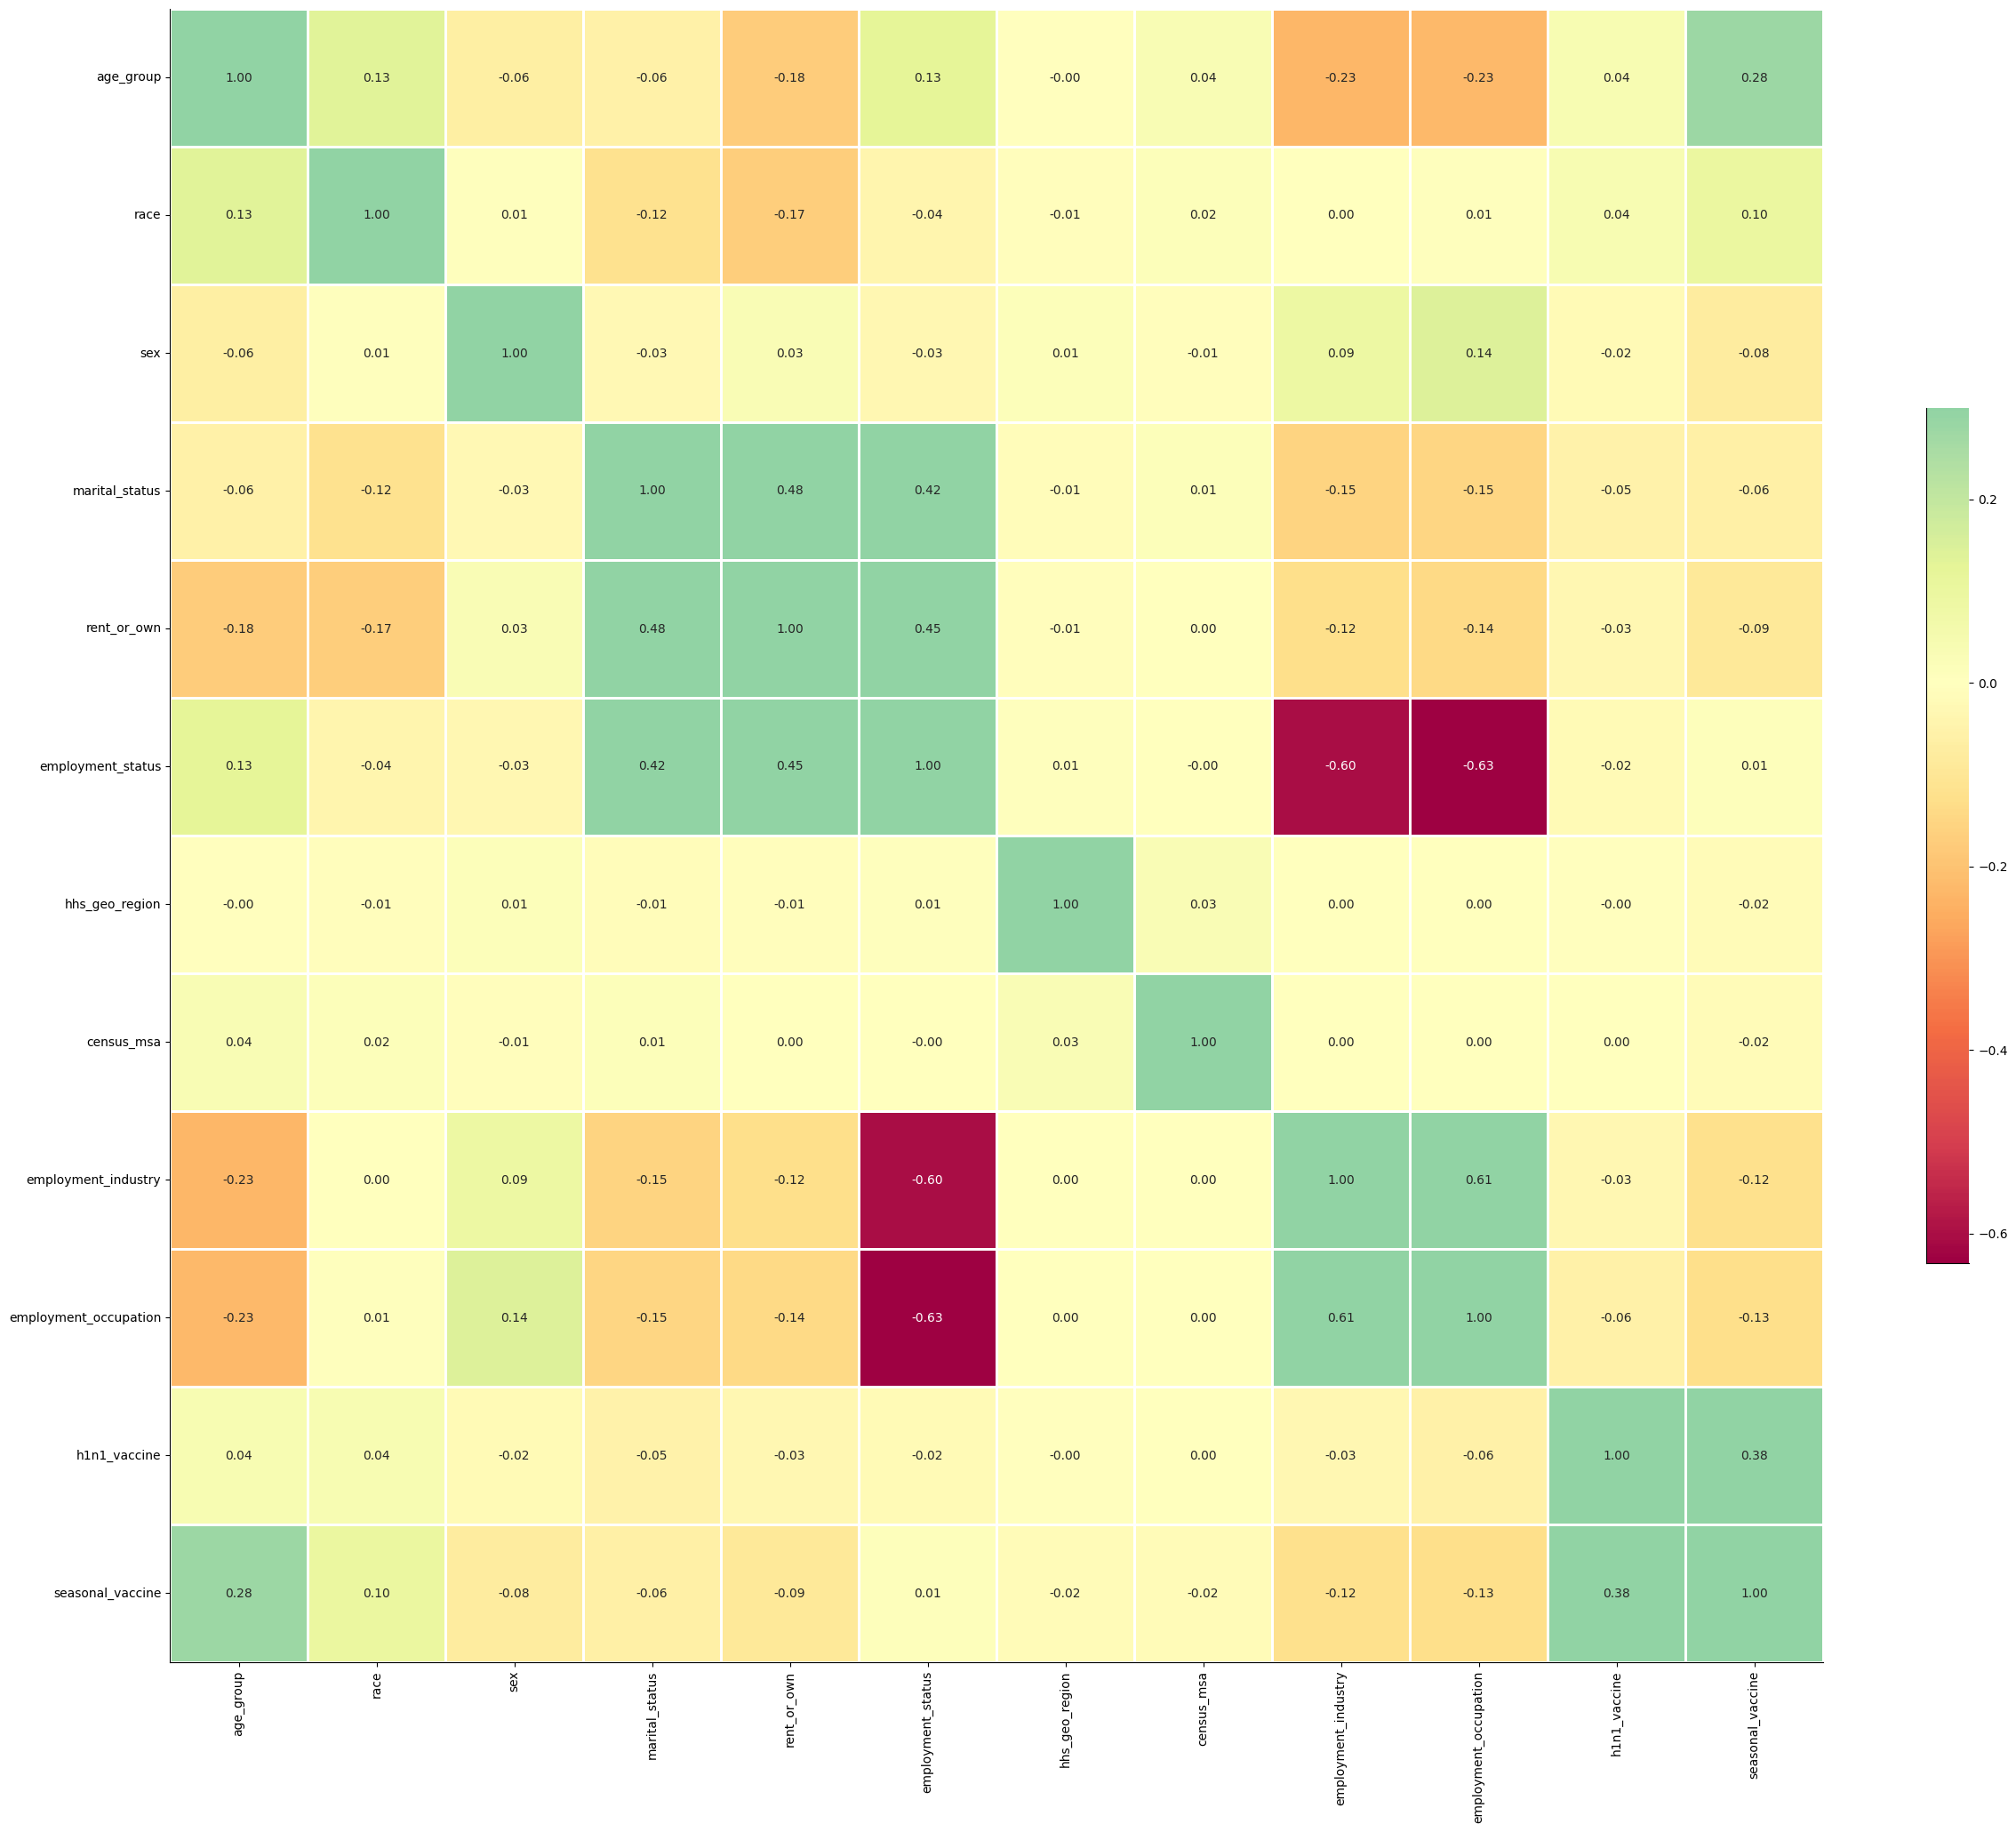

In [44]:
## Object data type correlation heatmap
corr = train_df_object.corr()
g = sns.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='Spectral')
sns.despine()
g.figure.set_size_inches(30,25)
    
plt.show()

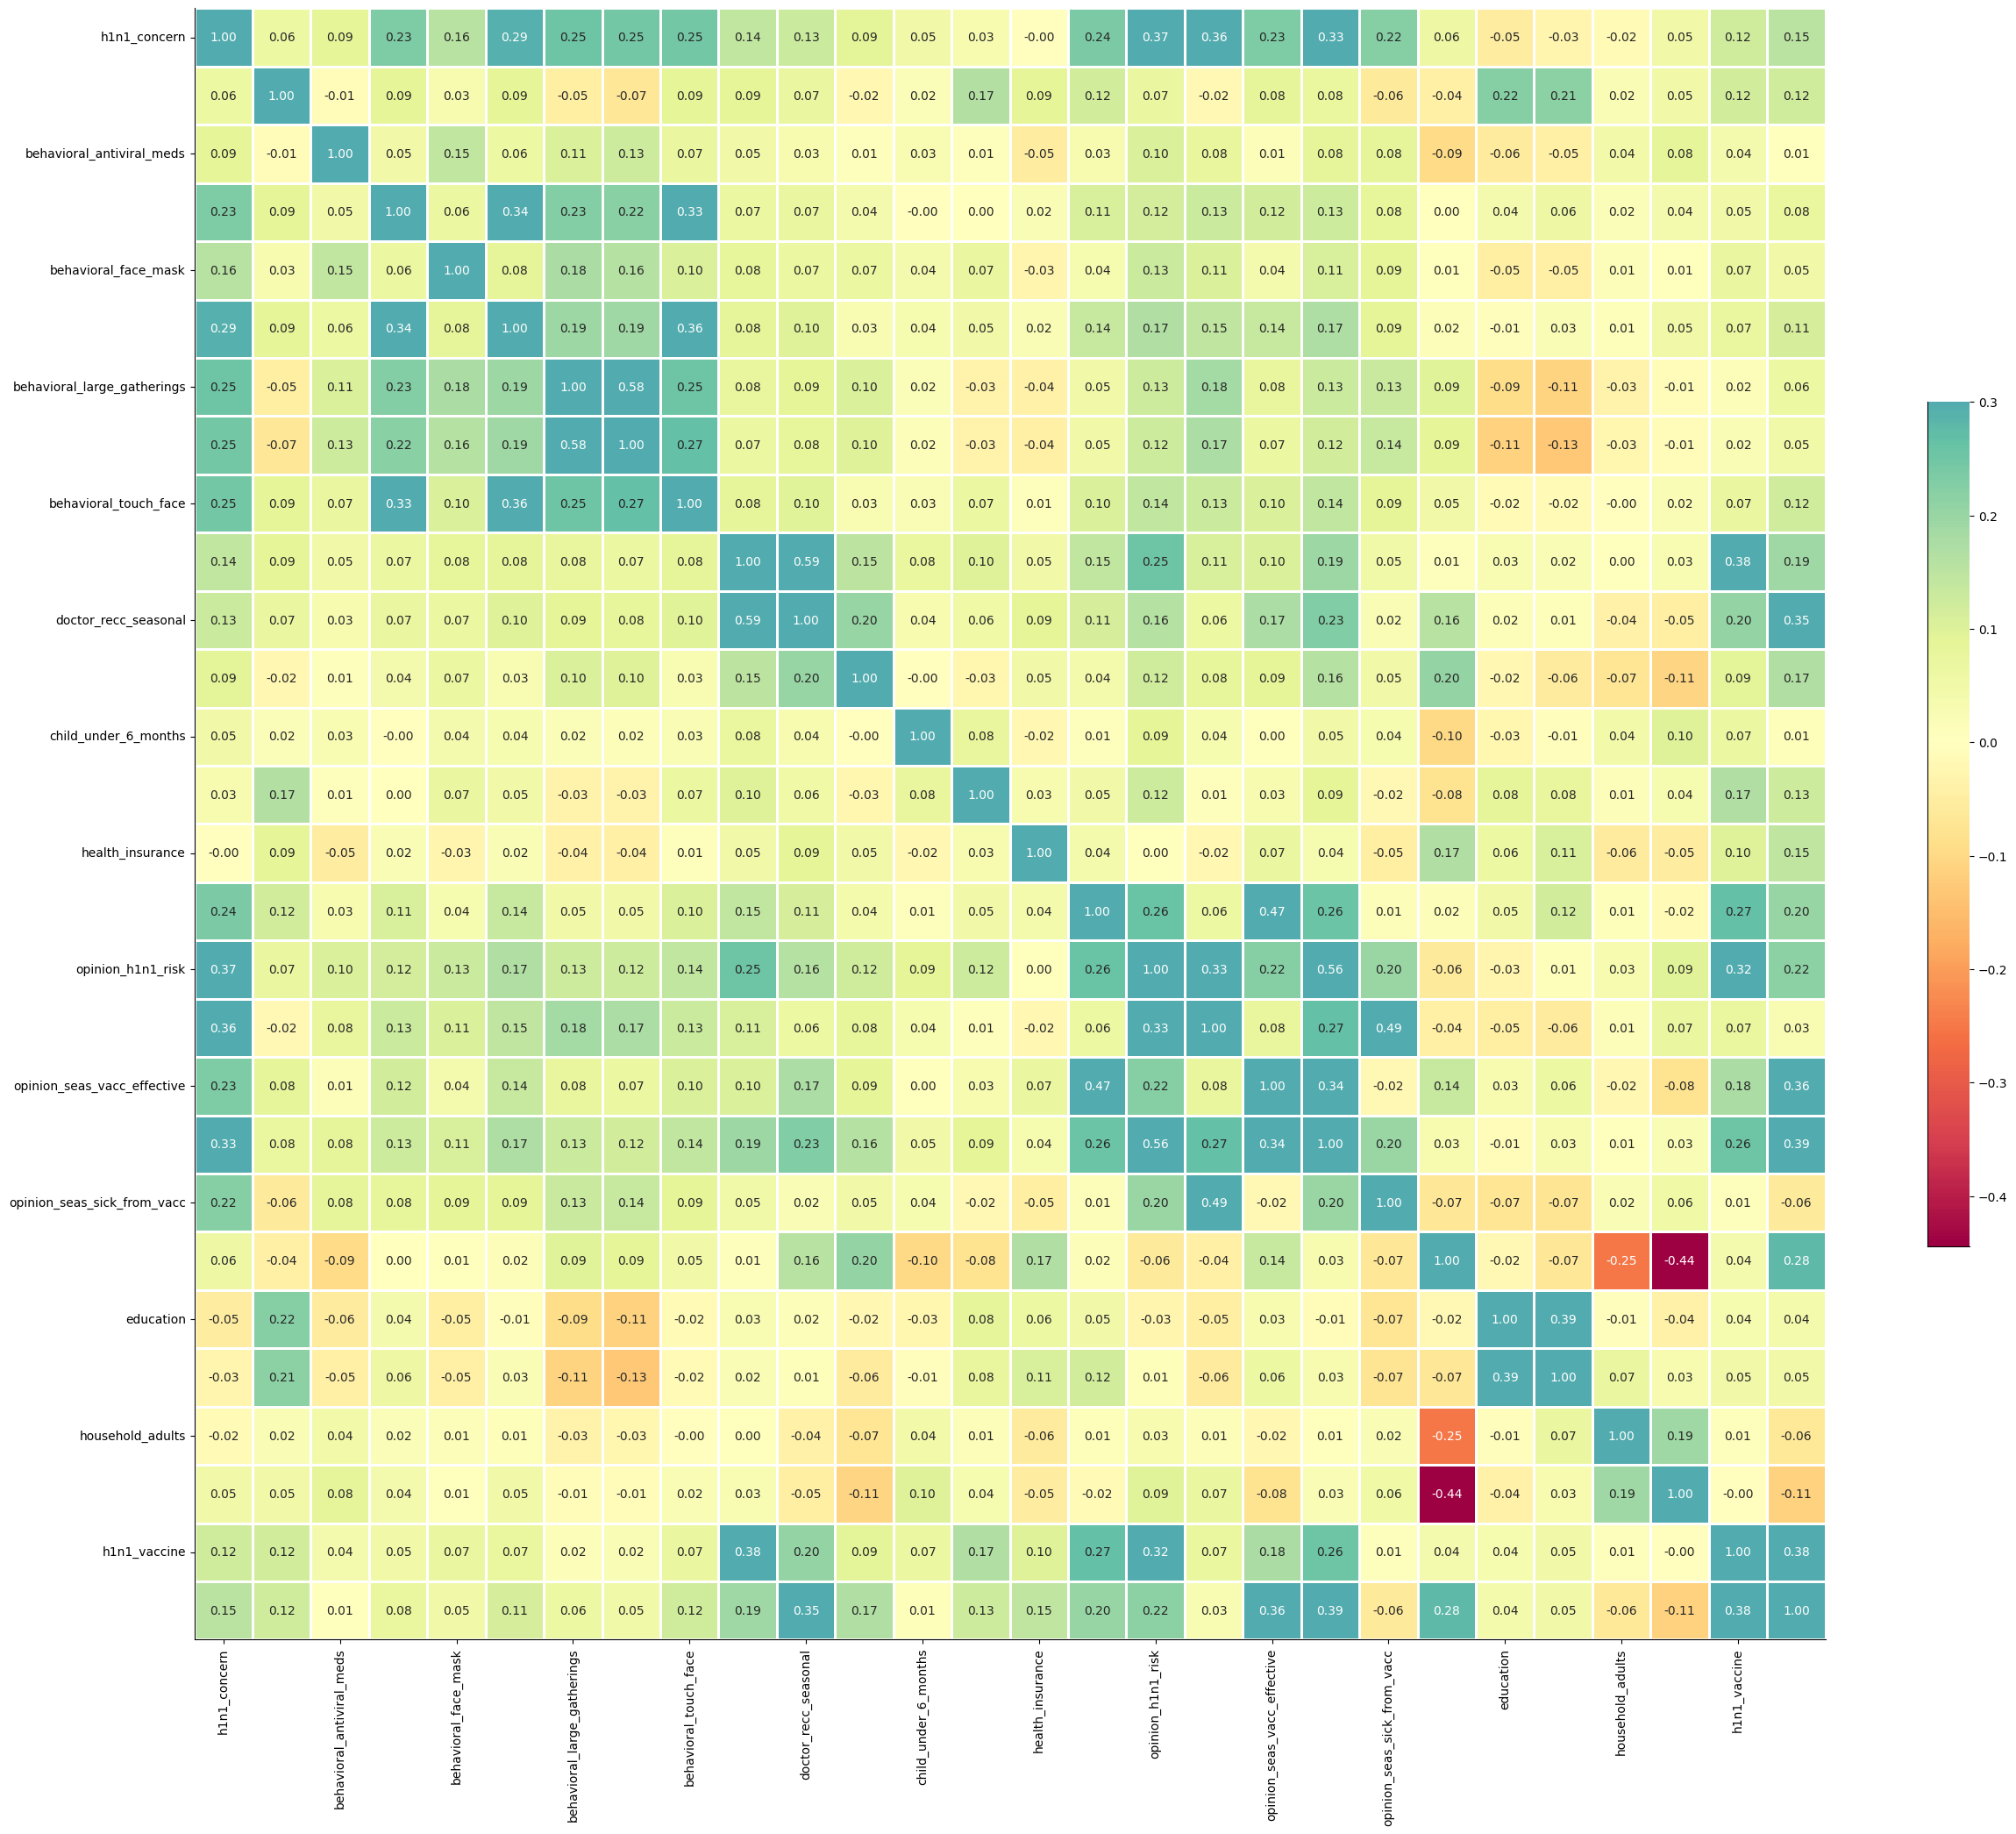

In [45]:
## Numerical feature correlation heatmap
corr = train_df_float.corr()
g = sns.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='Spectral')
sns.despine()
g.figure.set_size_inches(30,25)
    
plt.show()

Based on the observation above, we see that in the last two rows in each image that there are some features that has slight correlation to the target, whether it is the 'h1n1_vaccine' target or the 'seasonal_vaccine' one.

On the h1n1 side, we see that in the numerical plot that feature 'doctor_recc_h1n1' has 0.38 correlation score with 'h1n1_vaccine', while 'doctor_recc_seasonal' has 0.35 correlation score with 'seasonal_vaccine'. This indicates that respondents tend to take the vaccine based on the doctor recommendations.

Meanwhile on the object side, we see that the feature with the highest correlation to the target is 'age_group' with 'seasonal_vaccine'. While it has a good score with the target, the same does not apply to the 'h1n1_vaccine' target. This might be because 'seasonal_vaccine' is a more general vaccine to take than h1n1, and people at specific age group might take it regardless of whether they have seasonal flu or not. H1N1, on the other side, is a more specific case.

### Diving Deeper - Bar Plot

This time, we want to go specific to each features to see their distributions to the target labels.

#### Plotting the distribution of target labels

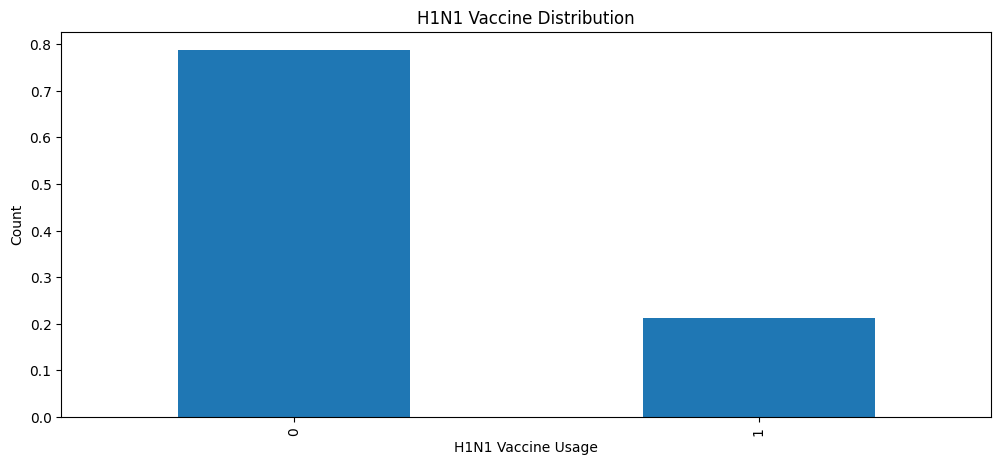

In [48]:
## H1n1 Vaccine target distribution
plt.figure(figsize = (12, 5))
ax = train_df.h1n1_vaccine.value_counts(normalize = True).plot(kind = "bar")

plt.title("H1N1 Vaccine Distribution")
plt.ylabel("Count")
plt.xlabel("H1N1 Vaccine Usage")
plt.show()

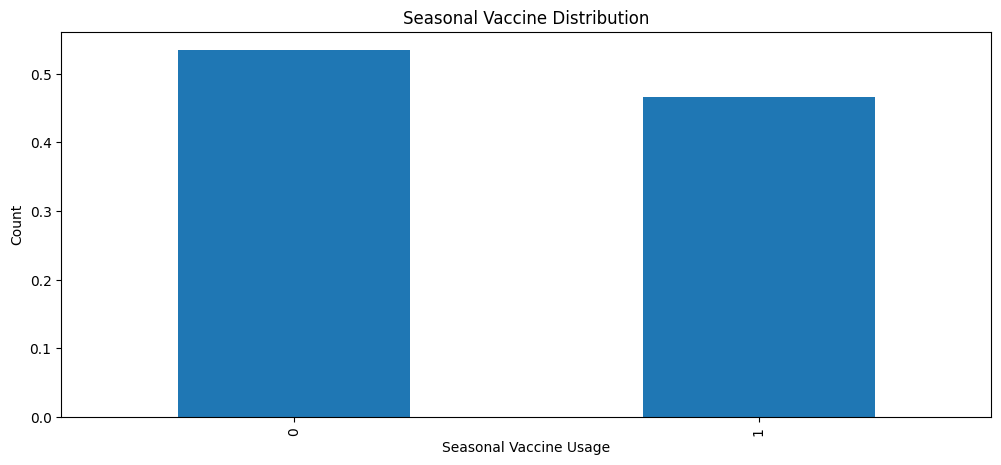

In [49]:
## Seasonal Vaccine target distribution
plt.figure(figsize = (12, 5))
ax = train_df.seasonal_vaccine.value_counts(normalize = True).plot(kind = "bar")

plt.title("Seasonal Vaccine Distribution")
plt.ylabel("Count")
plt.xlabel("Seasonal Vaccine Usage")
plt.show()

It seems like the H1N1 vaccine distribution is not balanced, with almost 80% of the recipients did not take the vaccine, while the seasonal vaccine distribution is more balanced.

#### Plotting all the distributions of all features

In [50]:
## Separating between numerical columns and categorical columns

num_cols = list(train_df.select_dtypes('float64').columns)
cat_cols = list(train_df.select_dtypes('object').columns)

We want to plot each column distributions to the target features

In [51]:
def target_distribution_plot(col, target, data, ax = None):
    counts = (train_df[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis = 'columns')
    props = counts.div(group_counts, axis = 'index')

    props.plot(kind = "bar", stacked = False, ax = ax)
    ax.legend().remove()
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)

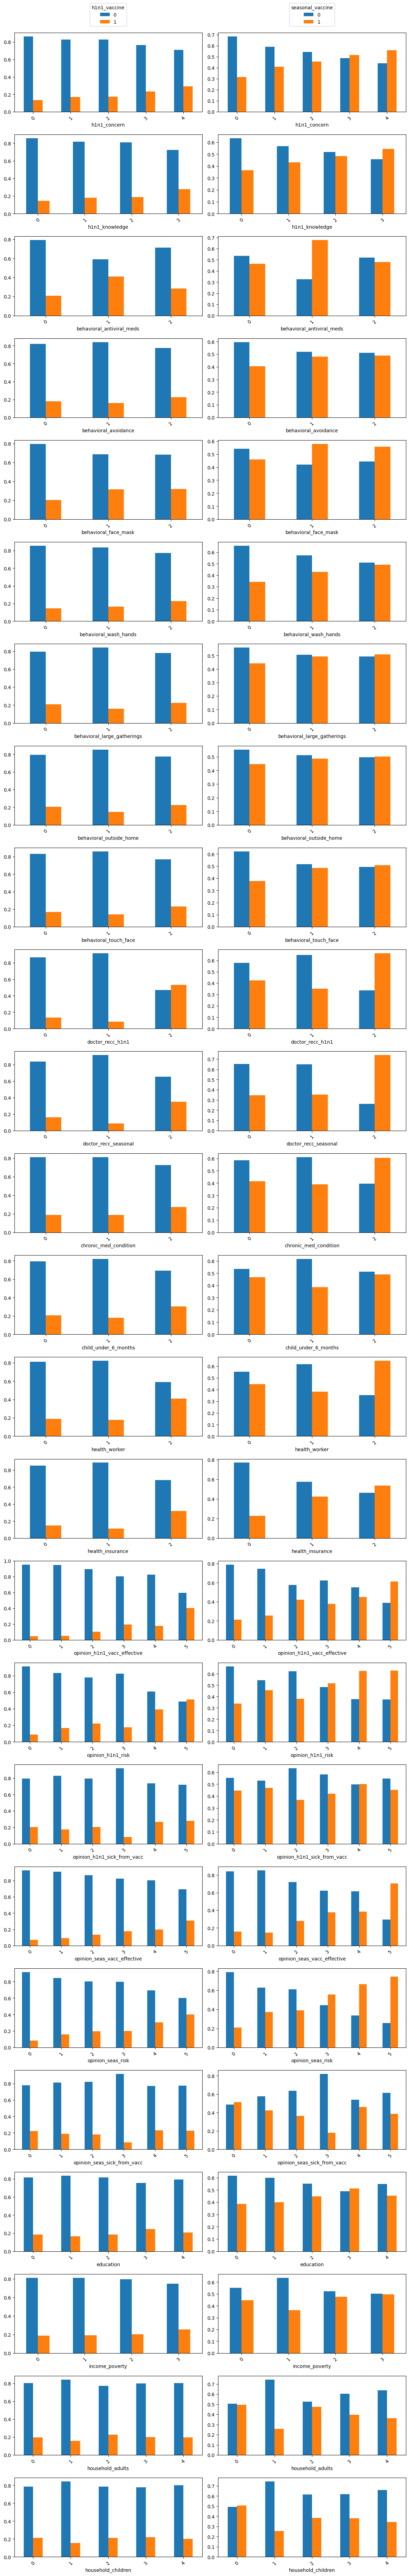

In [52]:
## Numerical Columns
fig, ax = plt.subplots(
    len(num_cols), 2, figsize=(12, len(num_cols)*3)
)
for idx, col in enumerate(num_cols):
    target_distribution_plot(
        col, 'h1n1_vaccine', train_df, ax=ax[idx, 0]
    )
    target_distribution_plot(
        col, 'seasonal_vaccine', train_df, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)

fig.tight_layout()

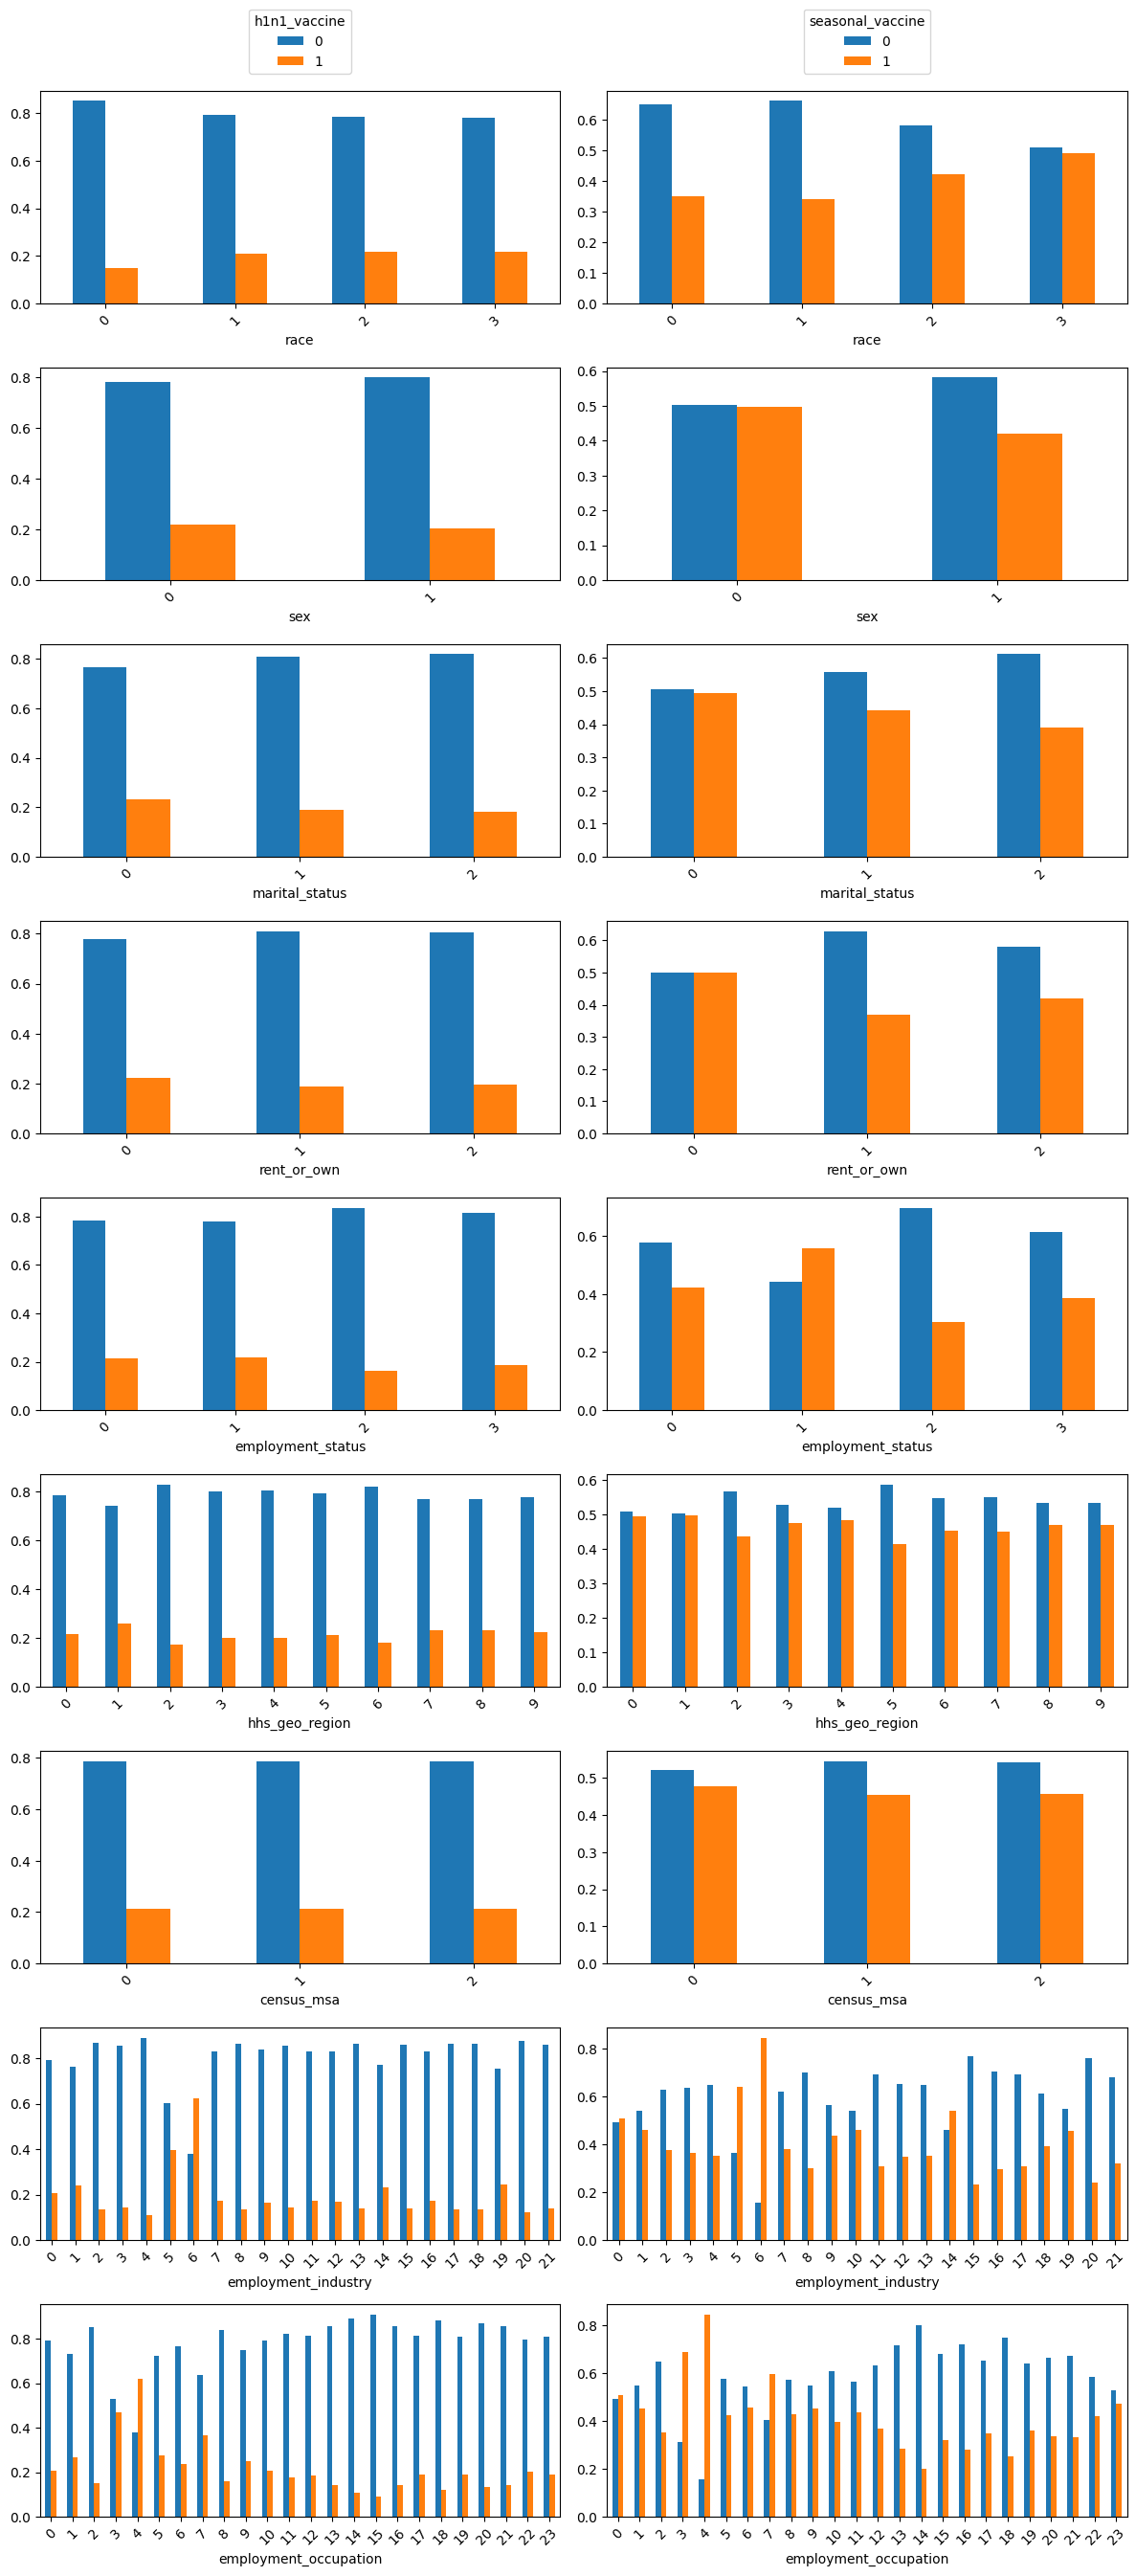

In [53]:
## Categorical Columns
fig, ax = plt.subplots(
    len(cat_cols), 2, figsize=(12, len(cat_cols)*3)
)
for idx, col in enumerate(cat_cols):
    target_distribution_plot(
        col, 'h1n1_vaccine', train_df, ax = ax[idx, 0]
    )
    target_distribution_plot(
        col, 'seasonal_vaccine', train_df, ax = ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc = 'lower center', bbox_to_anchor = (0.5, 1.05), title = 'h1n1_vaccine'
)
ax[0, 1].legend(
    loc = 'lower center', bbox_to_anchor = (0.5, 1.05), title = 'seasonal_vaccine'
)

fig.tight_layout()

We see that in the numerical side, each feature is mostly dominated by the 0 value of 'h1n1_vaccine' target, since it has the most occurence. We want our distributions to be balanced, like the 'seasonal_vaccine' target. So this is something to be noted.

## Feature Engineering

Based on the EDA above, we will then continue to the feature engineering step, which includes dealing with specific dataset or columns.

In [ ]:
display(train_df.columns)
display(test_df.columns)

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

First off, we want to replace the value names so that it is safe to be processed within any sklearn methods. In the 'dict_census' feature, some values has the coma symbol on it, so we want to remove it.

In [55]:
## Removing symbols from the feature values.

dict_census = {
    'MSA, Not Principle  City': 'MSA Not Principle City',
    'MSA, Principle City': 'MSA Principle City',
    'Non-MSA': 'Non MSA'
}

train_df['census_msa'] = train_df['census_msa'].replace(dict_census)
test_df['census_msa'] = test_df['census_msa'].replace(dict_census)

<ipython-input-55-298d9170784e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['census_msa'] = train_df['census_msa'].replace(dict_census)
<ipython-input-55-298d9170784e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['census_msa'] = test_df['census_msa'].replace(dict_census)


### One Hot Encoding

In [57]:
train_df.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                        int64
education                      float64
race                            object
sex                             object
income_poverty           

Reassign data types for the 'age_group' columns, since it has been encoded

In [58]:
train_df['age_group'] = train_df['age_group'].astype('float64')

<ipython-input-58-26cb4562cc8d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['age_group'] = train_df['age_group'].astype('float64')


We will specifically one-hot encode only the object part of the features, since it is natural to do so.

In [59]:
train_df_object = train_df.select_dtypes(['object', 'int64'])
train_df_numerical = train_df.select_dtypes(['float64', 'int64'])

In [60]:
## Checking all the columns to be encoded
train_df_object.columns

Index(['race', 'sex', 'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

In [61]:
## Creating a category list
categories = [
    ('race', train_df['race'].unique()),
    ('sex', train_df['sex'].unique()),
    ('marital_status', train_df['marital_status'].unique()),
    ('rent_or_own', train_df['rent_or_own'].unique()),
    ('employment_status', train_df['employment_status'].unique()),
    ('hhs_geo_region', train_df['hhs_geo_region'].unique()),
    ('census_msa', train_df['census_msa'].unique()),
    ('employment_industry', train_df['employment_industry'].unique()),
    ('employment_occupation', train_df['employment_occupation'].unique())
]

In [62]:
## Setting up one hot encoder for training set
train_df_engineered = train_df.copy()

ohe_columns_1 = [x[0] for x in categories]
ohe_categories_1 = [x[1] for x in categories]
enc_1 = OneHotEncoder(drop = 'first', sparse_output = False, categories = ohe_categories_1)

train_df_engineered_2 = pd.DataFrame(
    enc_1.fit_transform(train_df_engineered[ohe_columns_1]),
    columns = enc_1.get_feature_names_out(),
    index = train_df_engineered.index
)

train_df_engineered = pd.concat([train_df_engineered.drop(ohe_columns_1, axis = 1), train_df_engineered_2], axis = 1)

In [63]:
## Setting up one hot encoder for test set
test_df_engineered = test_df.copy()

ohe_columns_1 = [x[0] for x in categories]
ohe_categories_1 = [x[1] for x in categories]
enc_1 = OneHotEncoder(drop = 'first', sparse_output = False, categories = ohe_categories_1)

test_df_engineered_2 = pd.DataFrame(
    enc_1.fit_transform(test_df_engineered[ohe_columns_1]),
    columns = enc_1.get_feature_names_out(),
    index = test_df_engineered.index
)

test_df_engineered = pd.concat([test_df_engineered.drop(ohe_columns_1, axis = 1), test_df_engineered_2], axis = 1)

In [64]:
train_df_engineered

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_occupation_haliazsg,employment_occupation_dlvbwzss,employment_occupation_xzmlyyjv,employment_occupation_oijqvulv,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_hodpvpew,employment_occupation_uqqtjvyb,employment_occupation_pvmttkik,employment_occupation_dcjcmpih
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.221489,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
test_df_engineered

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_occupation_haliazsg,employment_occupation_dlvbwzss,employment_occupation_xzmlyyjv,employment_occupation_oijqvulv,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_hodpvpew,employment_occupation_uqqtjvyb,employment_occupation_pvmttkik,employment_occupation_dcjcmpih
respondent_id,,,,,,,,,,,,,,,,,,,,,
26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53410,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53411,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53412,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We now have encoded all the categorical features, which results in the column increase to 92.

### Feature Selection using ANOVA Test

All the 92 features will be selected based on their importance to the target. The reason is so the model is more optimized and more faster to predict values while maintaining the accuracy of the predictions. From this step, since we have two targets to be compared at, we will have two separate training features; one for H1N1 model, and one for the seasonal model.

In [66]:
train_df_engineered_2 = train_df_engineered.drop(columns = ['h1n1_vaccine', 'seasonal_vaccine']).select_dtypes(['float64', 'int64'])
test_df_engineered_2 = test_df_engineered.select_dtypes(['float64', 'int64'])

y = train_df_engineered[['h1n1_vaccine']]
y_2 = train_df_engineered[['seasonal_vaccine']]

#### H1N1 Model Feature Selection

In [67]:
## ANOVA test
f_score, p_value = f_regression(train_df_engineered_2, y)

f_test = pd.DataFrame()
f_test["Variable"] = train_df_engineered_2.columns
f_test["f_score"] = f_score
f_test["p_value"] = p_value

f_test = f_test.sort_values(by = ["f_score"],ascending = False)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [68]:
f_test

,Variable,f_score,p_value
9,doctor_recc_h1n1,4635.487508,0.000000e+00
16,opinion_h1n1_risk,3064.220820,0.000000e+00
15,opinion_h1n1_vacc_effective,2058.075274,0.000000e+00
19,opinion_seas_risk,1875.920689,0.000000e+00
10,doctor_recc_seasonal,1169.604380,6.382332e-251
...,...,...,...
47,census_msa_MSA Principle City,0.113482,7.362170e-01
76,employment_occupation_kldqjyjy,0.090450,7.636076e-01
39,hhs_geo_region_lrircsnp,0.062556,8.025030e-01
46,census_msa_MSA Not Principle City,0.044881,8.322240e-01


In [69]:
## Feature Selection
features_selected_h1n1 = np.array(f_test[(f_test["p_value"] < 0.05) & (~f_test["p_value"].isnull())]["Variable"])
train_df_engineered_h1n1 = train_df_engineered_2[features_selected_h1n1]
test_df_engineered_h1n1 = test_df_engineered_2[features_selected_h1n1]

In [70]:
train_df_engineered_h1n1['h1n1_vaccine'] = y

<ipython-input-70-c7ec32a0d36e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_engineered_h1n1['h1n1_vaccine'] = y


In [71]:
train_df_engineered_h1n1

,doctor_recc_h1n1,opinion_h1n1_risk,opinion_h1n1_vacc_effective,opinion_seas_risk,doctor_recc_seasonal,opinion_seas_vacc_effective,health_worker,employment_industry_fcxhlnwr,employment_occupation_cmhcxjea,h1n1_concern,...,marital_status_Unknown,employment_occupation_ccgxvspp,employment_industry_wlfvacwt,employment_status_Unknown,employment_occupation_bxpfxfdn,employment_occupation_dlvbwzss,hhs_geo_region_mlyzmhmf,rent_or_own_Unknown,employment_occupation_emcorrxb,h1n1_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,0.000000,1.0,3.0,1.0,0.000000,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.000000,4.0,5.0,2.0,0.000000,4.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.221489,1.0,3.0,1.0,0.331643,4.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.000000,3.0,3.0,4.0,1.000000,5.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.000000,3.0,3.0,1.0,0.000000,3.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,0.000000,1.0,3.0,2.0,0.000000,5.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
26703,1.000000,2.0,4.0,1.0,1.000000,5.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
26704,0.000000,4.0,4.0,4.0,0.000000,5.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


The feature selection results in reduced column numbers from 92 to 66.

#### Seasonal Feature Selection

In [72]:
## ANOVA test
f_score, p_value = f_regression(train_df_engineered_2, y_2)

f_test = pd.DataFrame()
f_test["Variable"] = train_df_engineered_2.columns
f_test["f_score"] = f_score
f_test["p_value"] = p_value

f_test = f_test.sort_values(by = ["f_score"],ascending = False)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [73]:
f_test

,Variable,f_score,p_value
19,opinion_seas_risk,4687.574100,0.000000e+00
18,opinion_seas_vacc_effective,3945.998711,0.000000e+00
10,doctor_recc_seasonal,3833.062233,0.000000e+00
21,age_group,2227.227052,0.000000e+00
16,opinion_h1n1_risk,1295.512797,4.459720e-277
...,...,...,...
88,employment_occupation_hodpvpew,0.157779,6.912124e-01
38,hhs_geo_region_qufhixun,0.110516,7.395606e-01
58,employment_industry_arjwrbjb,0.098514,7.536221e-01
84,employment_occupation_xzmlyyjv,0.038246,8.449512e-01


In [74]:
## Feature Selection
features_selected_seasonal = np.array(f_test[(f_test["p_value"] < 0.05) & (~f_test["p_value"].isnull())]["Variable"])
train_df_engineered_seasonal = train_df_engineered_2[features_selected_seasonal]
test_df_engineered_seasonal = test_df_engineered_2[features_selected_seasonal]

In [75]:
train_df_engineered_seasonal['seasonal_vaccine'] = y_2

<ipython-input-75-63364677d00c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_engineered_seasonal['seasonal_vaccine'] = y_2


In [76]:
train_df_engineered_seasonal

,opinion_seas_risk,opinion_seas_vacc_effective,doctor_recc_seasonal,age_group,opinion_h1n1_risk,opinion_h1n1_vacc_effective,doctor_recc_h1n1,chronic_med_condition,h1n1_concern,health_insurance,...,employment_industry_dotnnunm,employment_occupation_kldqjyjy,hhs_geo_region_atmpeygn,census_msa_MSA Principle City,employment_occupation_mxkfnird,employment_industry_phxvnwax,employment_industry_wlfvacwt,hhs_geo_region_dqpwygqj,employment_occupation_hfxkjkmi,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,2.0,0.000000,3.0,1.0,3.0,0.000000,0.0,1.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2.0,4.0,0.000000,1.0,4.0,5.0,0.000000,0.0,3.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1.0,4.0,0.331643,0.0,1.0,3.0,0.221489,1.0,1.0,0.883824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,4.0,5.0,1.000000,4.0,3.0,3.0,0.000000,1.0,1.0,0.883824,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
4,1.0,3.0,0.000000,2.0,3.0,3.0,0.000000,0.0,2.0,0.883824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,5.0,0.000000,4.0,1.0,3.0,0.000000,0.0,2.0,0.883824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
26703,1.0,5.0,1.000000,0.0,2.0,4.0,1.000000,0.0,1.0,1.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
26704,4.0,5.0,0.000000,3.0,4.0,4.0,0.000000,0.0,2.0,0.883824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### Upsampling with Borderline SMOTE

Based on EDA above, we see that H1N1 Vaccine is pretty imbalanced. We can do a technique called upsampling to balance the labels.
Since we have two labels to predict: h1n1_vaccine and seasonal_vaccine, and we have splitted the datasets into two, by the end of this part we will have:

- An upsampled dataset used to predict the h1n1_vaccine variable, where the upsampling process doesn't involve seasonal_variable as the feature used
- The original dataset used to predict the seasonal_vaccine variable, where the size doesn't change and will be less than the upsampled dataset.

In [77]:
from imblearn.over_sampling import BorderlineSMOTE, ADASYN
import math
def borderline_smote(x, y):
  k_neighbors = math.ceil(sum(y) * 0.01)
  m_neighbors = math.ceil(sum(y) * 0.01)

  bordersmote = BorderlineSMOTE(sampling_strategy = 1, k_neighbors = k_neighbors, m_neighbors = m_neighbors)

  x, y = bordersmote.fit_resample(x, y)

  return x, y

In [78]:
x_new, y_new = borderline_smote(train_df_engineered_h1n1.drop(columns = ['h1n1_vaccine']), train_df_engineered_h1n1['h1n1_vaccine'])

In [79]:
train_df_engineered_h1n1 = x_new.copy()

In [80]:
train_df_engineered_h1n1['h1n1_vaccine'] = y_new

To differentiate, 
- **train_df_engineered_seasonal** is the original dataset, with the size of 26707
- **train_df_engineered_h1n1** is the upsampled dataset, with the size of 42066

### Data Normalization

While it is not important to do since the data has no outliers, we can do it just to make sure. 

In [81]:
features_num_h1n1 = train_df_engineered_h1n1.drop(columns = ['h1n1_vaccine']).select_dtypes(np.number).columns
features_num_seasonal = train_df_engineered_seasonal.drop(columns = ['seasonal_vaccine']).select_dtypes(np.number).columns

minmax_scaler = MinMaxScaler()
train_df_engineered_h1n1[features_num_h1n1] = minmax_scaler.fit_transform(train_df_engineered_h1n1[features_num_h1n1])
train_df_engineered_seasonal[features_num_seasonal] = minmax_scaler.fit_transform(train_df_engineered_seasonal[features_num_seasonal])

test_df_engineered_h1n1[features_num_h1n1] = minmax_scaler.fit_transform(test_df_engineered_h1n1[features_num_h1n1])
test_df_engineered_seasonal[features_num_seasonal] = minmax_scaler.fit_transform(test_df_engineered_seasonal[features_num_seasonal])

<ipython-input-81-f201925447ed>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_engineered_seasonal[features_num_seasonal] = minmax_scaler.fit_transform(train_df_engineered_seasonal[features_num_seasonal])
<ipython-input-81-f201925447ed>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_engineered_h1n1[features_num_h1n1] = minmax_scaler.fit_transform(test_df_engineered_h1n1[features_num_h1n1])
<ipython-input-81-f201925447ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [82]:
train_df_engineered_h1n1.describe()

,doctor_recc_h1n1,opinion_h1n1_risk,opinion_h1n1_vacc_effective,opinion_seas_risk,doctor_recc_seasonal,opinion_seas_vacc_effective,health_worker,employment_industry_fcxhlnwr,employment_occupation_cmhcxjea,h1n1_concern,...,marital_status_Unknown,employment_occupation_ccgxvspp,employment_industry_wlfvacwt,employment_status_Unknown,employment_occupation_bxpfxfdn,employment_occupation_dlvbwzss,hhs_geo_region_mlyzmhmf,rent_or_own_Unknown,employment_occupation_emcorrxb,h1n1_vaccine
count,42066.000000,42066.000000,42066.000000,42066.000000,42066.000000,42066.000000,42066.000000,42066.000000,42066.000000,42066.000000,...,42066.000000,42066.000000,42066.000000,42066.000000,42066.000000,42066.000000,42066.000000,42066.000000,42066.000000,42066.000000
mean,0.302414,0.367039,0.751502,0.458825,0.370380,0.784116,0.120459,0.094911,0.047652,0.559492,...,0.056093,0.011151,0.007010,0.058753,0.012066,0.008847,0.082449,0.078351,0.046663,0.500000
std,0.425169,0.314360,0.230609,0.332663,0.447265,0.244955,0.305843,0.281818,0.204022,0.288661,...,0.227179,0.100493,0.079647,0.231655,0.103399,0.087361,0.260159,0.263028,0.202451,0.500006
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.142336,0.713045,0.250000,0.000000,0.750000,0.000000,0.000000,0.000000,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.250000,0.750000,0.250000,0.000000,0.750000,0.000000,0.000000,0.000000,0.666667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
75%,0.825649,0.750000,1.000000,0.750000,1.000000,1.000000,0.000000,0.000000,0.000000,0.666667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [83]:
train_df_engineered_seasonal.describe()

,opinion_seas_risk,opinion_seas_vacc_effective,doctor_recc_seasonal,age_group,opinion_h1n1_risk,opinion_h1n1_vacc_effective,doctor_recc_h1n1,chronic_med_condition,h1n1_concern,health_insurance,...,employment_industry_dotnnunm,employment_occupation_kldqjyjy,hhs_geo_region_atmpeygn,census_msa_MSA Principle City,employment_occupation_mxkfnird,employment_industry_phxvnwax,employment_industry_wlfvacwt,hhs_geo_region_dqpwygqj,employment_occupation_hfxkjkmi,seasonal_vaccine
count,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,...,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000
mean,0.429765,0.756494,0.329889,0.546533,0.335613,0.712645,0.220407,0.283220,0.539498,0.881606,...,0.007526,0.017561,0.076122,0.294455,0.056502,0.003332,0.008050,0.042161,0.028682,0.465608
std,0.342915,0.269281,0.450714,0.364330,0.319042,0.250008,0.397351,0.442323,0.302914,0.239143,...,0.086428,0.131351,0.265199,0.455806,0.230893,0.057632,0.089363,0.200961,0.166913,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.750000,0.000000,0.250000,0.000000,0.500000,0.000000,0.000000,0.333333,0.883824,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.250000,0.750000,0.000000,0.500000,0.250000,0.750000,0.000000,0.000000,0.666667,0.883824,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.750000,1.000000,1.000000,1.000000,0.750000,1.000000,0.221489,1.000000,0.666667,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Saving Finalized Data

In [84]:
train_df_engineered_h1n1.to_csv('train_df_engineered_h1n1.csv')
train_df_engineered_seasonal.to_csv('train_df_engineered_seasonal.csv')
test_df_engineered_h1n1.to_csv('test_df_engineered_h1n1.csv')
test_df_engineered_seasonal.to_csv('test_df_engineered_seasonal.csv')

In [85]:
!cp train_df_engineered_h1n1.csv '/content/drive/MyDrive/FindIT - DAC'

In [86]:
!cp train_df_engineered_seasonal.csv '/content/drive/MyDrive/FindIT - DAC'

In [87]:
!cp test_df_engineered_h1n1.csv '/content/drive/MyDrive/FindIT - DAC'

In [88]:
!cp test_df_engineered_seasonal.csv '/content/drive/MyDrive/FindIT - DAC'

## Modelling

In [89]:
train_df_seasonal = train_df_engineered_seasonal.copy()
train_df_h1n1 = train_df_engineered_h1n1.copy()
test_df_seasonal = test_df_engineered_seasonal.copy()
test_df_h1n1 = test_df_engineered_h1n1.copy()

### Model Tuning

The model we will be using is XGBoost. Before we do the predicting, we want to tune the model first to increase its performance.

In [ ]:
def report_perf(optimizer, X, y, title, callbacks = None):
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback = callbacks)
    else:
        optimizer.fit(X, y)
    best_score = optimizer.best_score_
    best_score_std = optimizer.cv_results_['std_test_score'][optimizer.best_index_]
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

#### H1N1 Model Tuning (using XGBClassifier)

In [ ]:
labels_h1n1 = ['h1n1_vaccine']
features_h1n1 = train_df_h1n1.drop(columns = ['h1n1_vaccine']).columns

train_h1n1, test_h1n1 = train_test_split(train_df_h1n1, test_size = 0.2, random_state = 42, shuffle = True)
x_train_h1n1, y_train_h1n1 = train_h1n1[features_h1n1], train_h1n1[labels_h1n1]
x_val_h1n1, y_val_h1n1 = test_h1n1[features_h1n1], test_h1n1[labels_h1n1]

In [ ]:
## Defining the base model
xgb_h1n1_untuned = XGBClassifier(tree_method = 'gpu_hist')

In [ ]:
search_spaces = {'learning_rate': Real(0.01, 1.0, 'uniform'),
                 'max_depth': Integer(2, 12),
                 'subsample': Real(0.1, 1.0, 'uniform'),
                 'colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
                 'reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
                 'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
                 'n_estimators': Integer(50, 5000)
   }

In [ ]:
opt_h1n1 = BayesSearchCV(estimator = xgb_h1n1_untuned,
                    search_spaces = search_spaces,
                    cv = 5,
                    n_jobs = 1,
                    n_iter = 10,
                    return_train_score = False,
                    refit = True,
                    iid = False,                                        # if not iid it optimizes on the cv score                                                               
                    optimizer_kwargs = {'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state = 0,
                    verbose = 100)

In [ ]:
best_params_xgb_h1n1 = report_perf(opt_h1n1, x_train_h1n1, y_train_h1n1,'XGBoost', 
                          callbacks = [DeltaYStopper(0.0001)])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START colsample_bytree=0.5778677484569327, learning_rate=0.6793187137881445, max_depth=8, n_estimators=3251, reg_alpha=85.87438316565517, reg_lambda=98.05562626781331, subsample=0.21526179068277768
[CV 1/5; 1/1] END colsample_bytree=0.5778677484569327, learning_rate=0.6793187137881445, max_depth=8, n_estimators=3251, reg_alpha=85.87438316565517, reg_lambda=98.05562626781331, subsample=0.21526179068277768;, score=0.889 total time=   3.8s
[CV 2/5; 1/1] START colsample_bytree=0.5778677484569327, learning_rate=0.6793187137881445, max_depth=8, n_estimators=3251, reg_alpha=85.87438316565517, reg_lambda=98.05562626781331, subsample=0.21526179068277768
[CV 2/5; 1/1] END colsample_bytree=0.5778677484569327, learning_rate=0.6793187137881445, max_depth=8, n_estimators=3251, reg_alpha=85.87438316565517, reg_lambda=98.05562626781331, subsample=0.21526179068277768;, score=0.886 total time=   3.6s
[CV 3/5; 1/1] START colsample_b

#### Seasonal Model Tuning (using XGBClassifier)

In [ ]:
labels_seasonal = ['seasonal_vaccine']
features_seasonal = train_df_seasonal.drop(columns = ['seasonal_vaccine']).columns

train_seasonal, test_seasonal = train_test_split(train_df_seasonal, test_size = 0.2, random_state = 42, shuffle = True)
x_train_seasonal, y_train_seasonal = train_seasonal[features_seasonal], train_seasonal[labels_seasonal]
x_val_seasonal, y_val_seasonal = test_seasonal[features_seasonal], test_seasonal[labels_seasonal]

In [ ]:
## Defining the base model
xgb_seasonal_untuned = XGBClassifier(tree_method = 'gpu_hist')

In [ ]:
search_spaces = {
    'learning_rate': Real(0.01, 1.0, 'uniform'),
    'max_depth': Integer(2, 12),
    'subsample': Real(0.1, 1.0, 'uniform'),
    'colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
    'reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
    'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
    'n_estimators': Integer(50, 5000)
}

In [ ]:
opt_seasonal = BayesSearchCV(estimator = xgb_seasonal_untuned,
                    search_spaces = search_spaces,
                    cv = 5,
                    n_jobs = 1,
                    n_iter = 10,
                    return_train_score = False,
                    refit = True,
                    iid = False,                                        # if not iid it optimizes on the cv score                                                               
                    optimizer_kwargs = {'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state = 0,
                    verbose = 100)

/opt/conda/lib/python3.10/site-packages/skopt/searchcv.py:300: UserWarning: The `iid` parameter has been deprecated and will be ignored.
  warnings.warn("The `iid` parameter has been deprecated "


In [ ]:
best_params_xgb_seasonal = report_perf(opt_seasonal, x_train_seasonal, y_train_seasonal,'XGBoost', 
                          callbacks = [DeltaYStopper(0.0001)])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START colsample_bytree=0.5778677484569327, learning_rate=0.6793187137881445, max_depth=8, n_estimators=3251, reg_alpha=85.87438316565517, reg_lambda=98.05562626781331, subsample=0.21526179068277768
[CV 1/5; 1/1] END colsample_bytree=0.5778677484569327, learning_rate=0.6793187137881445, max_depth=8, n_estimators=3251, reg_alpha=85.87438316565517, reg_lambda=98.05562626781331, subsample=0.21526179068277768;, score=0.782 total time=   3.8s
[CV 2/5; 1/1] START colsample_bytree=0.5778677484569327, learning_rate=0.6793187137881445, max_depth=8, n_estimators=3251, reg_alpha=85.87438316565517, reg_lambda=98.05562626781331, subsample=0.21526179068277768
[CV 2/5; 1/1] END colsample_bytree=0.5778677484569327, learning_rate=0.6793187137881445, max_depth=8, n_estimators=3251, reg_alpha=85.87438316565517, reg_lambda=98.05562626781331, subsample=0.21526179068277768;, score=0.768 total time=   3.1s
[CV 3/5; 1/1] START colsample_b

### 1st Model: H1N1 Vaccine Model, using Upsampled Data

The dataset to be used: **train_df_h1n1**

In [90]:
labels_h1n1 = ['h1n1_vaccine']
features_h1n1 = train_df_h1n1.drop(columns = ['h1n1_vaccine']).columns

In [91]:
train_h1n1, test_h1n1 = train_test_split(train_df_h1n1, test_size = 0.2, random_state = 42, shuffle = True)

x_train_h1n1, y_train_h1n1 = train_h1n1[features_h1n1], train_h1n1[labels_h1n1]
x_val_h1n1, y_val_h1n1 = test_h1n1[features_h1n1], test_h1n1[labels_h1n1]

In [93]:
# Setting the basic classifier
xgb_cl_h1n1_tuned = XGBClassifier(
    tree_method='gpu_hist',
    colsample_bytree = 0.5758225678679059,
    learning_rate = 0.06731886525659495,
    max_depth = 5,
    n_estimators = 998,
    reg_alpha = 24.04631523135751,
    reg_lambda = 34.21270253201294,
    subsample = 0.6778671495585501
)

In [94]:
x_train_h1n1

,doctor_recc_h1n1,opinion_h1n1_risk,opinion_h1n1_vacc_effective,opinion_seas_risk,doctor_recc_seasonal,opinion_seas_vacc_effective,health_worker,employment_industry_fcxhlnwr,employment_occupation_cmhcxjea,h1n1_concern,...,behavioral_large_gatherings,marital_status_Unknown,employment_occupation_ccgxvspp,employment_industry_wlfvacwt,employment_status_Unknown,employment_occupation_bxpfxfdn,employment_occupation_dlvbwzss,hhs_geo_region_mlyzmhmf,rent_or_own_Unknown,employment_occupation_emcorrxb
32225,1.000000,0.250000,0.984313,0.718626,1.000000,0.750000,0.000000,0.000000,0.0,0.645751,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
28560,0.000000,0.334539,0.334539,0.750000,0.000000,1.000000,0.000000,0.169077,0.0,0.666667,...,0.830923,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
37924,0.293895,0.926526,1.000000,0.396948,0.293895,0.926526,0.000000,0.000000,0.0,0.902035,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
41169,0.187047,0.320663,0.717829,0.400727,0.280071,0.794240,0.094338,0.000000,0.0,0.948166,...,0.155503,1.0,0.0,0.0,1.0,0.0,0.0,0.000000,1.0,0.0
40853,0.396887,0.099222,0.750000,0.900778,0.603113,0.750000,0.000000,0.000000,0.0,0.666667,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.603113,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,0.000000,0.750000,1.000000,0.750000,1.000000,1.000000,0.000000,0.000000,0.0,0.666667,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
11284,0.000000,0.750000,0.750000,0.250000,0.000000,0.750000,0.000000,0.000000,0.0,0.333333,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
38158,1.000000,0.250000,1.000000,0.195229,1.000000,0.750000,0.219084,0.219084,0.0,0.406361,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
860,0.000000,0.250000,0.750000,0.250000,0.000000,0.750000,0.000000,0.000000,0.0,0.666667,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [ ]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
cv_scores = cross_val_score(xgb_cl_h1n1_tuned, x_train_h1n1, y_train_h1n1, cv = kf, scoring = 'roc_auc')

print(cv_scores)
print("Mean Score: " + str(cv_scores.mean()))

[0.96166506 0.96482134 0.96542314 0.96420784 0.96566202]
Mean Score: 0.9643558803761518


In [95]:
xgb_cl_h1n1_tuned.fit(x_train_h1n1, y_train_h1n1)
probs_h1n1 = xgb_cl_h1n1_tuned.predict(x_val_h1n1)
probs_h1n1_proba = xgb_cl_h1n1_tuned.predict_proba(x_val_h1n1)[:, 1]

print("Tuned XGB classifier ROC AUC Score: " + str(roc_auc_score(y_val_h1n1, probs_h1n1_proba)))
print("Tuned XGB classifier F1 Score: " + str(f1_score(y_val_h1n1, probs_h1n1, average = 'macro')))

Tuned XGB classifier ROC AUC Score: 0.9646480258329414
Tuned XGB classifier F1 Score: 0.9119304473945216


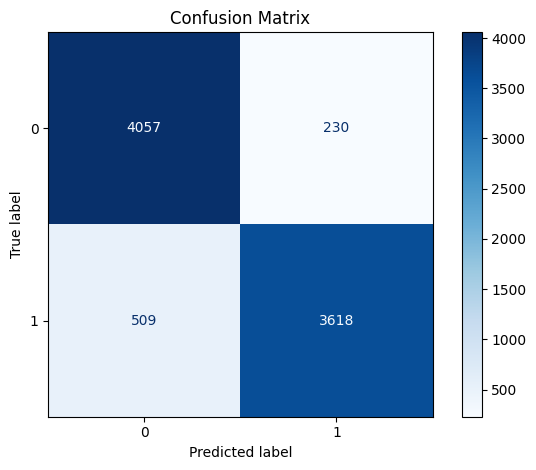

In [96]:
plt.style.use('default')
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_val_h1n1, probs_h1n1), display_labels=['0', '1'])
disp.plot(cmap = 'Blues', values_format = '')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

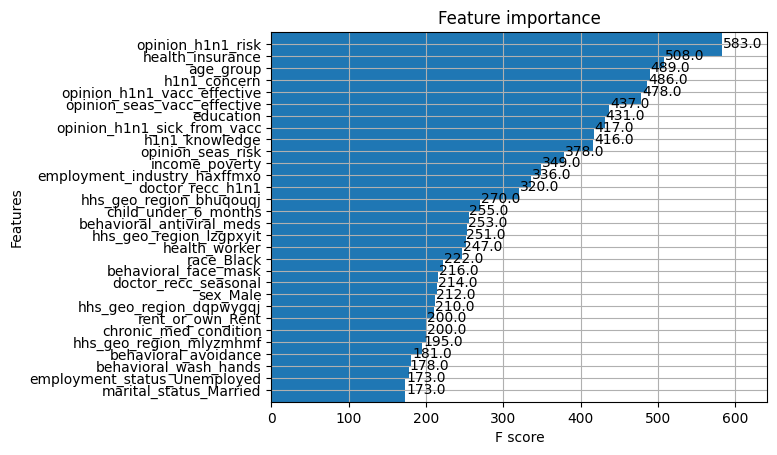

In [97]:
_ = plot_importance(xgb_cl_h1n1_tuned, height = 2.0, max_num_features = 30)

### 2nd Model: Seasonal Vaccine (using full data)

Dataset to be used: **train_df_seasonal**

In [98]:
labels_seasonal = ['seasonal_vaccine']
features_seasonal = train_df_seasonal.drop(columns = ['seasonal_vaccine']).columns

In [99]:
train_seasonal, test_seasonal = train_test_split(train_df_seasonal, test_size = 0.2, random_state = 42, shuffle = True)

x_train_seasonal, y_train_seasonal = train_seasonal[features_seasonal], train_seasonal[labels_seasonal]
x_val_seasonal, y_val_seasonal = test_seasonal[features_seasonal], test_seasonal[labels_seasonal]

In [100]:
# Setting the basic classifier
xgb_cl_seasonal_tuned = XGBClassifier(
    tree_method='gpu_hist',
    colsample_bytree = 0.5758225678679059,
    learning_rate = 0.06731886525659495,
    max_depth = 5,
    n_estimators = 998,
    reg_alpha = 24.04631523135751,
    reg_lambda = 34.21270253201294,
    subsample = 0.6778671495585501
)

In [ ]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
cv_scores = cross_val_score(xgb_cl_seasonal_tuned, x_train_seasonal, y_train_seasonal, cv = kf, scoring = 'roc_auc')

print(cv_scores)
print("Mean Score: " + str(cv_scores.mean()))

[0.87149421 0.85946669 0.86535977 0.85403936 0.86258539]
Mean Score: 0.8625890827103364


In [101]:
xgb_cl_seasonal_tuned.fit(x_train_seasonal, y_train_seasonal)
probs_seasonal = xgb_cl_seasonal_tuned.predict(x_val_seasonal)
probs_seasonal_proba = xgb_cl_seasonal_tuned.predict_proba(x_val_seasonal)[:, 1]

print("Tuned XGB classifier ROC AUC Score: " + str(roc_auc_score(y_val_seasonal, probs_seasonal_proba)))
print("Tuned XGB classifier F1 Score: " + str(f1_score(y_val_seasonal, probs_seasonal, average = 'macro')))

Tuned XGB classifier ROC AUC Score: 0.8670304625802358
Tuned XGB classifier F1 Score: 0.7906744175684752


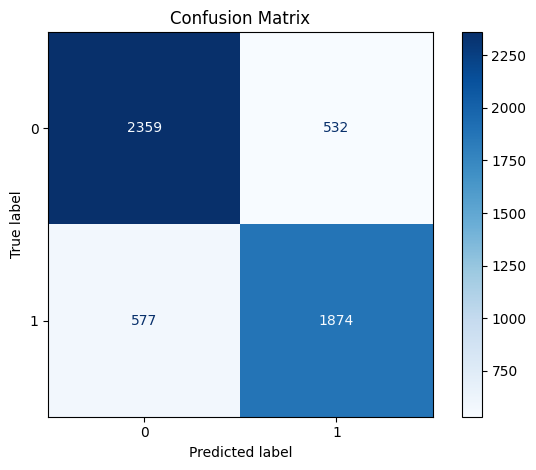

In [102]:
plt.style.use('default')
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_val_seasonal, probs_seasonal), display_labels=['0', '1'])
disp.plot(cmap = 'Blues', values_format = '')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

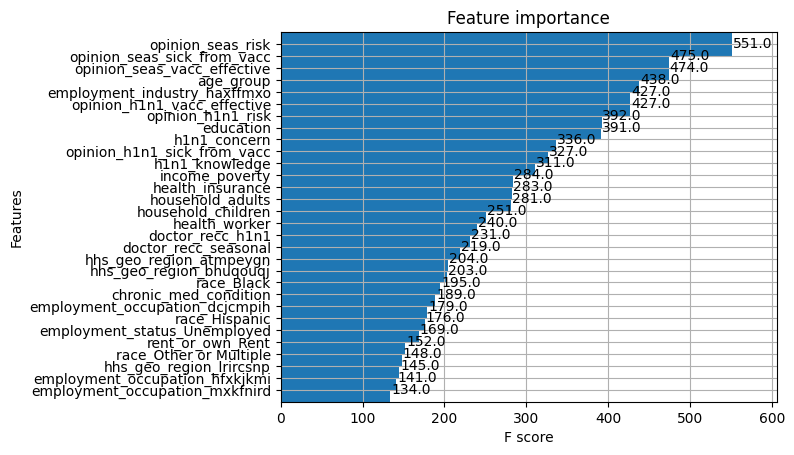

In [103]:
_ = plot_importance(xgb_cl_seasonal_tuned, height = 2.0, max_num_features = 30)

### Predicting

In [104]:
label_1 = xgb_cl_h1n1_tuned.predict_proba(test_df_h1n1)

In [105]:
label_2 = xgb_cl_seasonal_tuned.predict_proba(test_df_seasonal)

In [106]:
label_1.shape

(26708, 2)

In [107]:
label_1[:, 1]

array([0.12550244, 0.05037265, 0.16662005, ..., 0.2056903 , 0.02608997,
       0.63910675], dtype=float32)

In [108]:
submissions

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.5,0.7
26708,0.5,0.7
26709,0.5,0.7
26710,0.5,0.7
26711,0.5,0.7
...,...,...
53410,0.5,0.7
53411,0.5,0.7
53412,0.5,0.7


In [109]:
submissions_2 = submissions.copy()

In [110]:
submissions_2['h1n1_vaccine'] = label_1[:, 1]
submissions_2['seasonal_vaccine'] = label_2[:, 1]

In [111]:
submissions_2.dtypes

h1n1_vaccine        float32
seasonal_vaccine    float32
dtype: object

In [112]:
submissions_2

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.125502,0.321299
26708,0.050373,0.034180
26709,0.166620,0.749469
26710,0.696980,0.863954
26711,0.294855,0.485614
...,...,...
53410,0.184729,0.560059
53411,0.182949,0.284594
53412,0.205690,0.159885


In [113]:
submissions_2[['h1n1_vaccine', 'seasonal_vaccine']] = submissions_2[['h1n1_vaccine', 'seasonal_vaccine']].astype('float64')

In [114]:
submissions_2

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.125502,0.321299
26708,0.050373,0.034180
26709,0.166620,0.749469
26710,0.696980,0.863954
26711,0.294855,0.485614
...,...,...
53410,0.184729,0.560059
53411,0.182949,0.284594
53412,0.205690,0.159885


### Exporting Submission

In [ ]:
submissions_2.to_csv('submission_16.csv', index = True)